# Analyzing the data of the COVID-19 pandemic

In [243]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import urllib.request

import datetime
from datetime import datetime

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output, display

### Just some matplotlib and seaborn parameter tuning

In [244]:
out = './out/'
figsave_format = 'png'
figsave_dpi = 200
pad_inches = 0.15

# Axis size parameters
fig_x = 17
fig_y = 11
axistitlesize = 22
axisticksize_date = 13
axisticksize_y = 18
axislabelsize = 30
axistextsize = 14
axislegendsize = 20

# "Source text" position
text_x = 0.16
text_y = -0.15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colors
cases_color = 'yellow'
recov_color = 'darkturquoise'
death_color = 'tab:red'

## Load and preprocess pandemic data

### Prepare date format

In [245]:
from matplotlib import ticker
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

In [246]:
date_format = mdates.DateFormatter('%b %d \'%y')

In [247]:
def create_date_ticks(dates):
    # Empirical observation, that 22 x-ticks should be on the figures to look nicely
    N = 22
    step_size = int(len(dates) / N)
    date_ticks = np.append(dates[:-int(step_size/1.4):step_size], dates[-1])
    
    return date_ticks

In [248]:
date_cols = data_cases.columns[4:]
dates = np.array([datetime.strptime(d, '%m/%d/%y') for d in date_cols])
date_ticks = create_date_ticks(dates)

### Aggregate datasets

In [249]:
url_cases = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
)
url_recov = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
)
url_death = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
)

url_US_cases = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
)
url_US_death = (
    'https://raw.githubusercontent.com/' +
    'CSSEGISandData/COVID-19/' +
    'master/' +
    'csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
)

In [250]:
# Load .csv formatted datafiles
with urllib.request.urlopen(url_cases) as url:
    data_cases = pd.read_csv(url, sep=',', comment='#', header=0)
with urllib.request.urlopen(url_recov) as url:
    data_recov = pd.read_csv(url, sep=',', comment='#', header=0)
with urllib.request.urlopen(url_death) as url:
    data_death = pd.read_csv(url, sep=',', comment='#', header=0)
    
with urllib.request.urlopen(url_US_cases) as url:
    data_US_cases = pd.read_csv(url, sep=',', comment='#', header=0)
with urllib.request.urlopen(url_US_death) as url:
    data_US_death = pd.read_csv(url, sep=',', comment='#', header=0)

#### Aggregate world data

In [251]:
sum_cases = {}
sum_recov = {}
sum_death = {}

for idx, d in enumerate(date_cols):
    sum_cases[d] = data_cases[d].values.sum()
    sum_recov[d] = data_recov[d].values.sum()
    sum_death[d] = data_death[d].values.sum()

sum_cases = pd.Series(data=sum_cases)
sum_recov = pd.Series(data=sum_recov)
sum_death = pd.Series(data=sum_death)

In [252]:
regions = data_cases['Country/Region'].unique()
region_cases = data_cases.groupby(by='Country/Region', group_keys=False)[date_cols].agg('sum')
region_recov = data_recov.groupby(by='Country/Region', group_keys=False)[date_cols].agg('sum')
region_death = data_death.groupby(by='Country/Region', group_keys=False)[date_cols].agg('sum')

#### Aggregate US data

In [253]:
data_US_cases = data_US_cases.groupby(by='Province_State', group_keys=False).agg('sum')[date_cols]
data_US_death = data_US_death.groupby(by='Province_State', group_keys=False).agg('sum')[date_cols]

## Case number plots

### Official number of cases

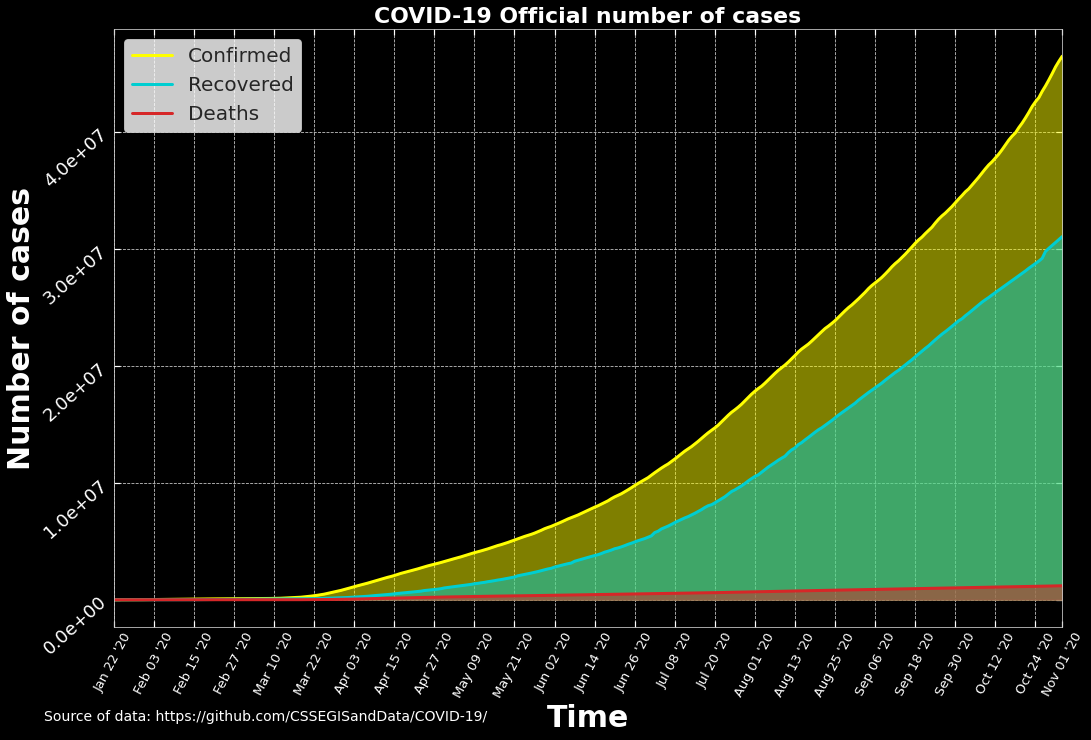

In [254]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*fig_x, nrows*fig_y),
                         facecolor='black', subplot_kw=dict(facecolor='black'))

# CASES
axes.plot(dates, sum_cases, label='Confirmed',
          c=cases_color, lw=3)
axes.fill_between(dates, sum_cases, color=cases_color, alpha=0.5)

# RECOV
axes.plot(dates, sum_recov, label='Recovered',
          c=recov_color, lw=3)
axes.fill_between(dates, sum_recov, color=recov_color, alpha=0.5)

# DEATH
axes.plot(dates, sum_death, label='Deaths',
          c=death_color, lw=3)
axes.fill_between(dates, sum_death, color=death_color, alpha=0.5)

# Source text
axes.text(x=text_x, y=text_y, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
          c='white', fontsize=axistextsize, fontweight='book',
          horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
          bbox=dict(facecolor='black', alpha=0.2, lw=0))

axes.set_title('COVID-19 Official number of cases', 
               fontsize=axistitlesize, fontweight='bold', color='white')

# X-AXIS FORMATTING
axes.set_xlabel('Time', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='x', which='major', labelsize=axisticksize_date, colors='white')
axes.set_xticks(date_ticks)
axes.set_xticklabels(date_ticks, rotation=62, ha='center')
axes.xaxis.set_major_formatter(date_format)
axes.set_xlim(dates[0], dates[-1])

# Y-AXIS FORMATTING
axes.set_ylabel('Number of cases', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='y', which='major', labelrotation=42, labelsize=axisticksize_y, colors='white')
axes.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))

axes.legend(loc='upper left', fontsize=axislegendsize)

plt.savefig(out + 'time_series.png',
            format=figsave_format, dpi=figsave_dpi,
            pad_inches=pad_inches,
            facecolor='black', edgecolor='black')

plt.show()

### Adjusted number of cases

In [255]:
adj_cases = sum_cases['2/13/20'] - sum_cases['2/12/20']
adj_recov = sum_recov['2/13/20'] - sum_recov['2/12/20']
adj_death = sum_death['2/13/20'] - sum_death['2/12/20']

sum_cases_adj = sum_cases.copy()
sum_recov_adj = sum_recov.copy()
sum_death_adj = sum_death.copy()

adj_dates = ['2/8/20','2/9/20','2/10/20','2/11/20','2/12/20'] 
for m, d in enumerate(adj_dates):
    sum_cases_adj[d] += adj_cases * (m+1)/6
    sum_recov_adj[d] += adj_recov * (m+1)/6
    sum_death_adj[d] += adj_death * (m+1)/6

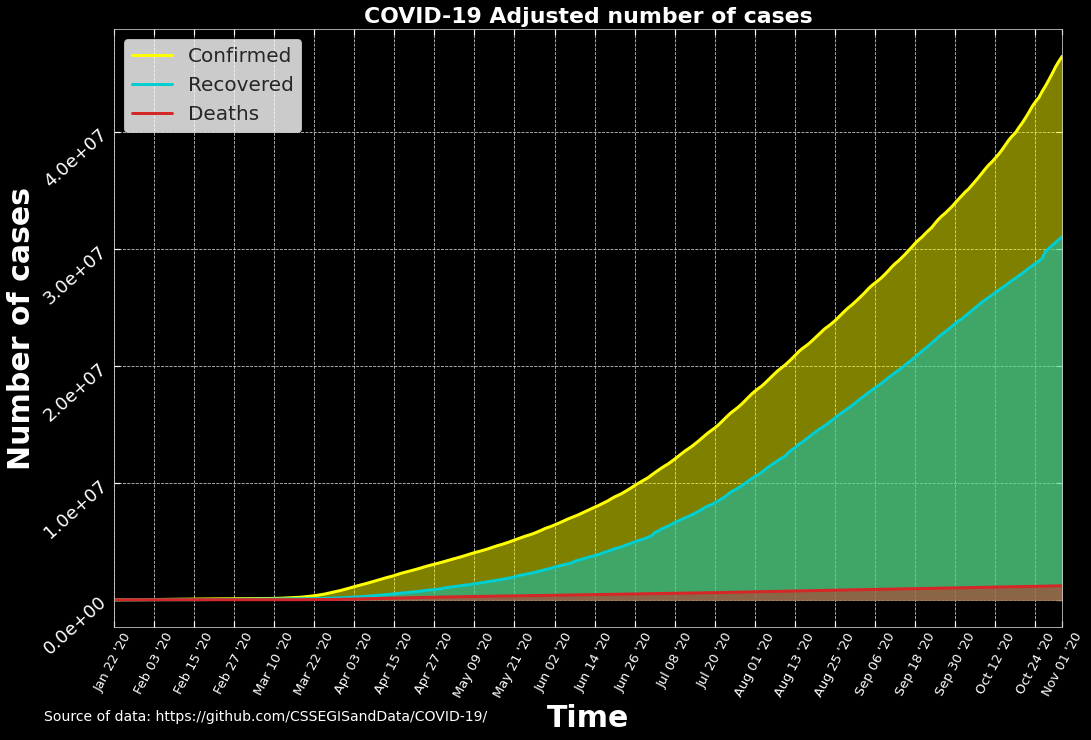

In [256]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*fig_x, nrows*fig_y),
                         facecolor='black', subplot_kw=dict(facecolor='black'))

# CASES
axes.plot(dates, sum_cases_adj, label='Confirmed',
          c=cases_color, lw=3)
axes.fill_between(dates, sum_cases_adj, color=cases_color, alpha=0.5)

# RECOV
axes.plot(dates, sum_recov_adj, label='Recovered',
          c=recov_color, lw=3)
axes.fill_between(dates, sum_recov_adj, color=recov_color, alpha=0.5)

# DEATH
axes.plot(dates, sum_death_adj, label='Deaths',
          c=death_color, lw=3)
axes.fill_between(dates, sum_death_adj, color=death_color, alpha=0.5)

# Source text
axes.text(x=text_x, y=text_y, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
          c='white', fontsize=axistextsize, fontweight='book',
          horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
          bbox=dict(facecolor='black', alpha=0.2, lw=0))

axes.set_title('COVID-19 Adjusted number of cases', 
               fontsize=axistitlesize, fontweight='bold', color='white')

# X-AXIS FORMATTING
axes.set_xlabel('Time', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='x', which='major', labelsize=axisticksize_date, colors='white')
axes.set_xticks(date_ticks)
axes.set_xticklabels(date_ticks, rotation=62, ha='center')
axes.xaxis.set_major_formatter(date_format)
axes.set_xlim(dates[0], dates[-1])

# Y-AXIS FORMATTING
axes.set_ylabel('Number of cases', fontsize=axislabelsize, fontweight='bold', color='white')
axes.tick_params(axis='y', which='major', labelrotation=42, labelsize=axisticksize_y, colors='white')
axes.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))

axes.legend(loc='upper left', fontsize=axislegendsize)

plt.savefig(out + 'time_series_adj.png',
            format=figsave_format, dpi=figsave_dpi,
            pad_inches=pad_inches,
            facecolor='black', edgecolor='black')

plt.show()

## Cases per country/region

In [257]:
def plot_region(region, mode='full'):
    
    nrows = 1
    ncols = 1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*fig_x, nrows*fig_y),
                             facecolor='black', subplot_kw=dict(facecolor='black'))

    if mode.lower()=='full':
        # CASES
        axes.plot(dates, region_cases.loc[region], label='Confirmed',
                  c=cases_color, lw=3)
        axes.fill_between(dates, region_cases.loc[region], color=cases_color, alpha=0.5)

        # RECOV
        axes.plot(dates, region_recov.loc[region], label='Recovered',
                  c=recov_color, lw=3)
        axes.fill_between(dates, region_recov.loc[region], color=recov_color, alpha=0.5)

        # DEATH
        axes.plot(dates, region_death.loc[region], label='Deaths',
                  c=death_color, lw=3)
        axes.fill_between(dates, region_death.loc[region], color=death_color, alpha=0.5)
        
        # TITLE
        axes.set_title('COVID-19 Official number of historical cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')

    elif mode.lower()=='total':
        # TOTAL ACTIVE
        region_total = region_cases.loc[region] - region_recov.loc[region] - region_death.loc[region]
        axes.plot(dates, region_total, label='Active total',
                  c=cases_color, lw=3)
        axes.fill_between(dates, region_total, color=cases_color, alpha=0.5)
        
        # TITLE
        axes.set_title('COVID-19 Official number of active cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')
    
    elif mode.lower()=='daily':
        region_daily = np.zeros_like(region_cases.loc[region])
        
        # Set starting day value
        region_daily[0] = 0
        for i in range(len(region_cases.loc[region][1:])):
            now = region_cases.loc[region][i+1]
            prev = region_cases.loc[region][i]
            
            region_daily[i+1] = now - prev
            
        # DAILY
        axes.plot(dates, region_daily, label='Daily',
              c=cases_color, lw=3)
        axes.fill_between(dates, region_daily, color=cases_color, alpha=0.5)

        # TITLE
        axes.set_title('COVID-19 Official number of daily cases - {}'.format(region), 
                   fontsize=axistitlesize, fontweight='bold', color='white')
        
    
    else:
        raise AttributeError('Modes should be \'total\' or \'full\'')
        
    # Source text
    axes.text(x=text_x, y=text_y, s='Source of data: https://github.com/CSSEGISandData/COVID-19/',
              c='white', fontsize=axistextsize, fontweight='book',
              horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,
              bbox=dict(facecolor='black', alpha=0.2, lw=0))

    axes.set_xlabel('Time', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.set_ylabel('Number of cases', fontsize=axislabelsize, fontweight='bold', color='white')

    # X-AXIS FORMATTING
    axes.set_xlabel('Time', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.tick_params(axis='x', which='major', labelsize=axisticksize_date, colors='white')
    axes.set_xticks(date_ticks)
    axes.set_xticklabels(date_ticks, rotation=62, ha='center')
    axes.xaxis.set_major_formatter(date_format)
    axes.set_xlim(dates[0], dates[-1])

    # Y-AXIS FORMATTING
    axes.set_ylabel('Number of cases', fontsize=axislabelsize, fontweight='bold', color='white')
    axes.tick_params(axis='y', which='major', labelrotation=42, labelsize=axisticksize_y, colors='white')
    axes.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))

    axes.legend(loc='upper left', fontsize=axislegendsize)

    plt.savefig(out + 'time_series_{0}_{1}.png'.format(region.lower().replace(' ', ''), mode.lower()),
                format=figsave_format, dpi=figsave_dpi,
                pad_inches=0.2,
                facecolor='black', edgecolor='black')

    plt.show()

## Regions -- Central Europe

### Hungary

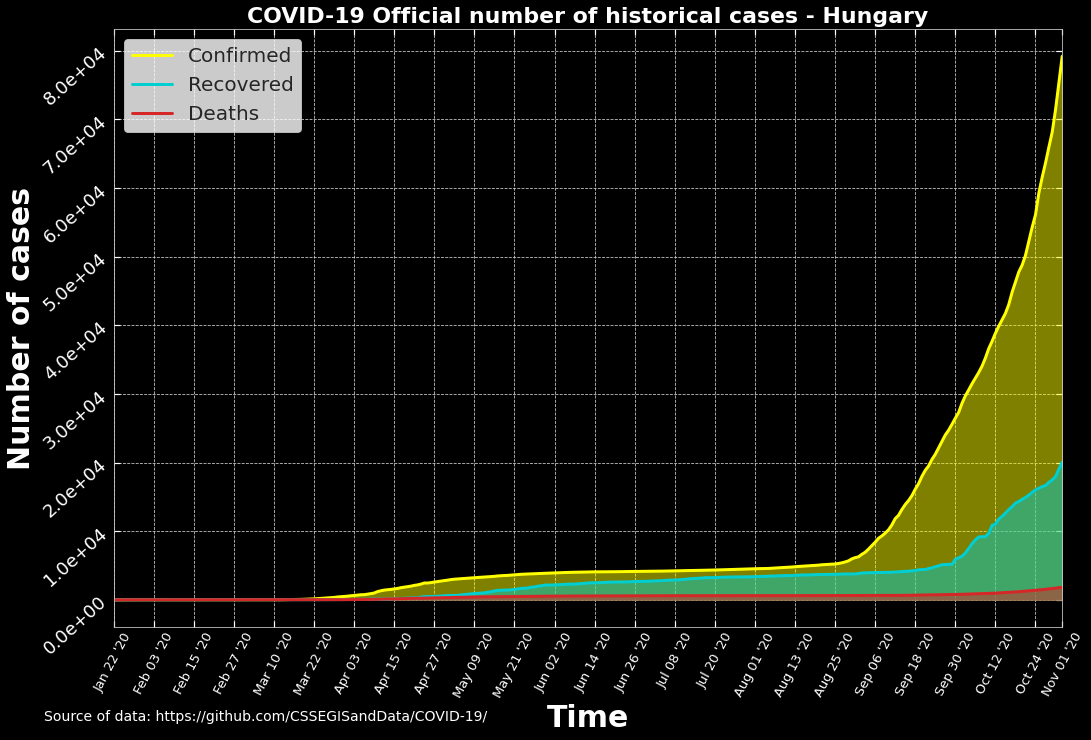

In [258]:
plot_region(region='Hungary', mode='full')

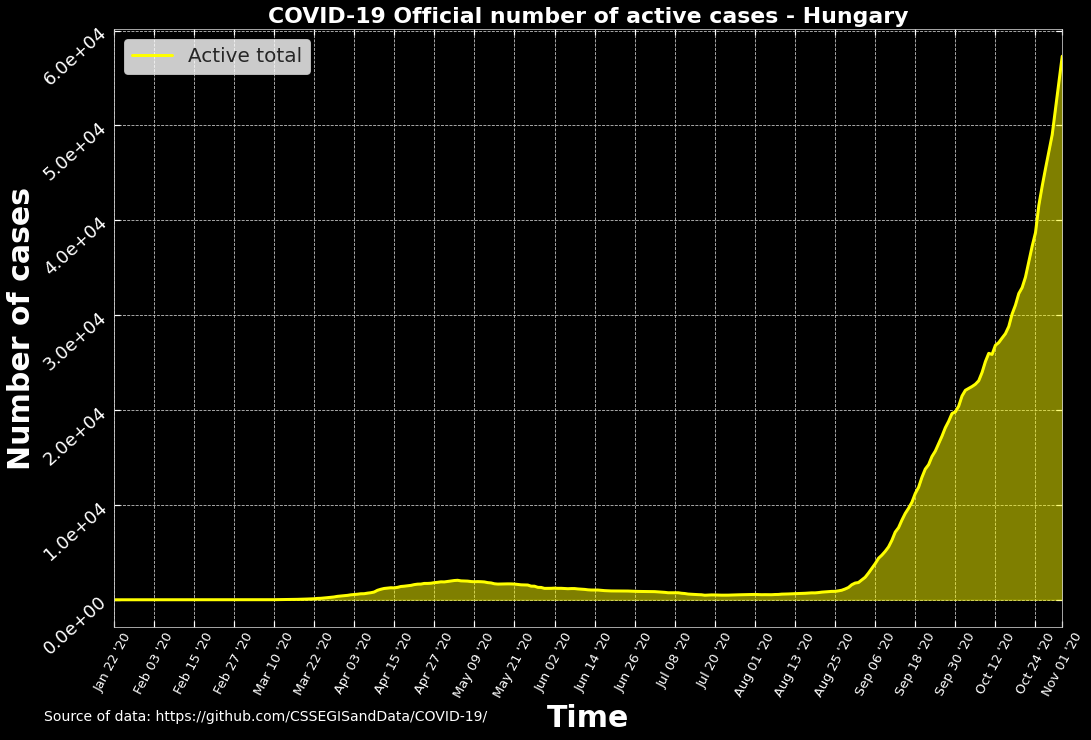

In [259]:
plot_region(region='Hungary', mode='total')

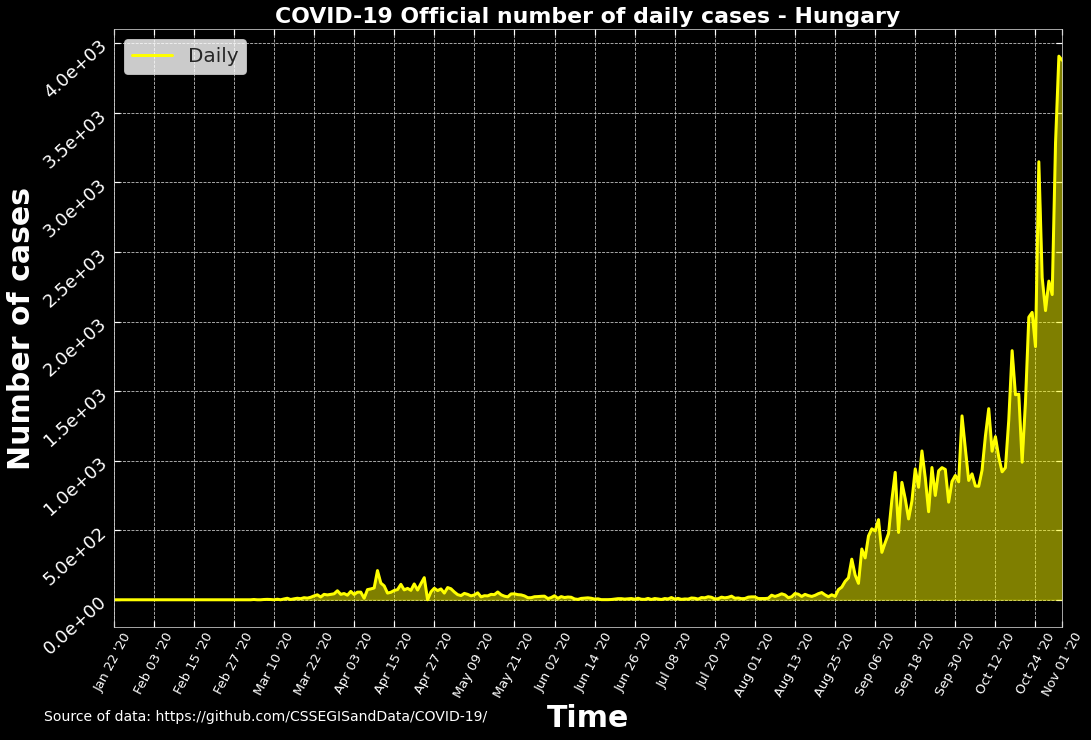

In [260]:
plot_region(region='Hungary', mode='daily')

### Austria

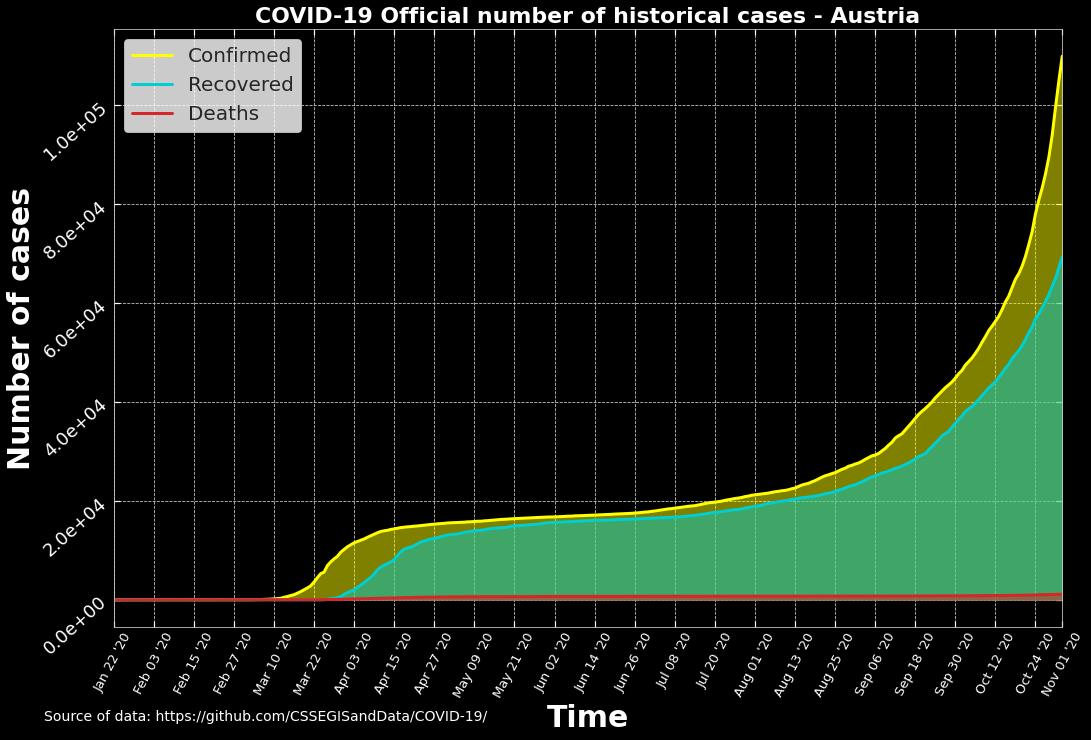

In [261]:
plot_region(region='Austria', mode='full')

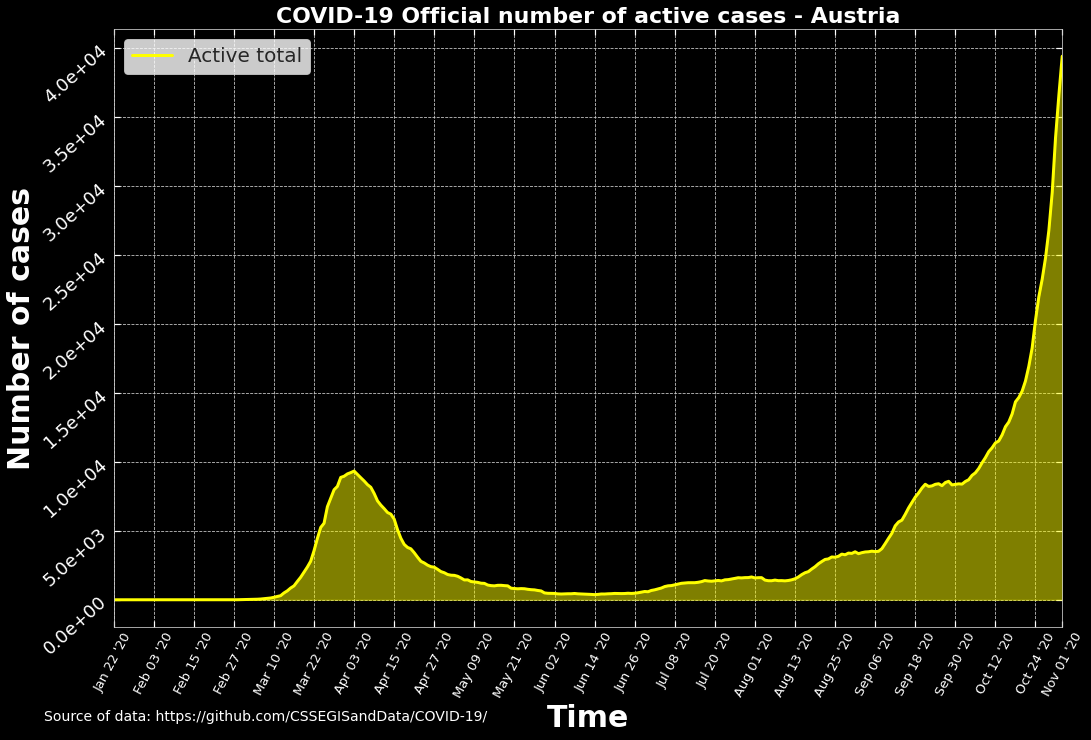

In [262]:
plot_region(region='Austria', mode='total')

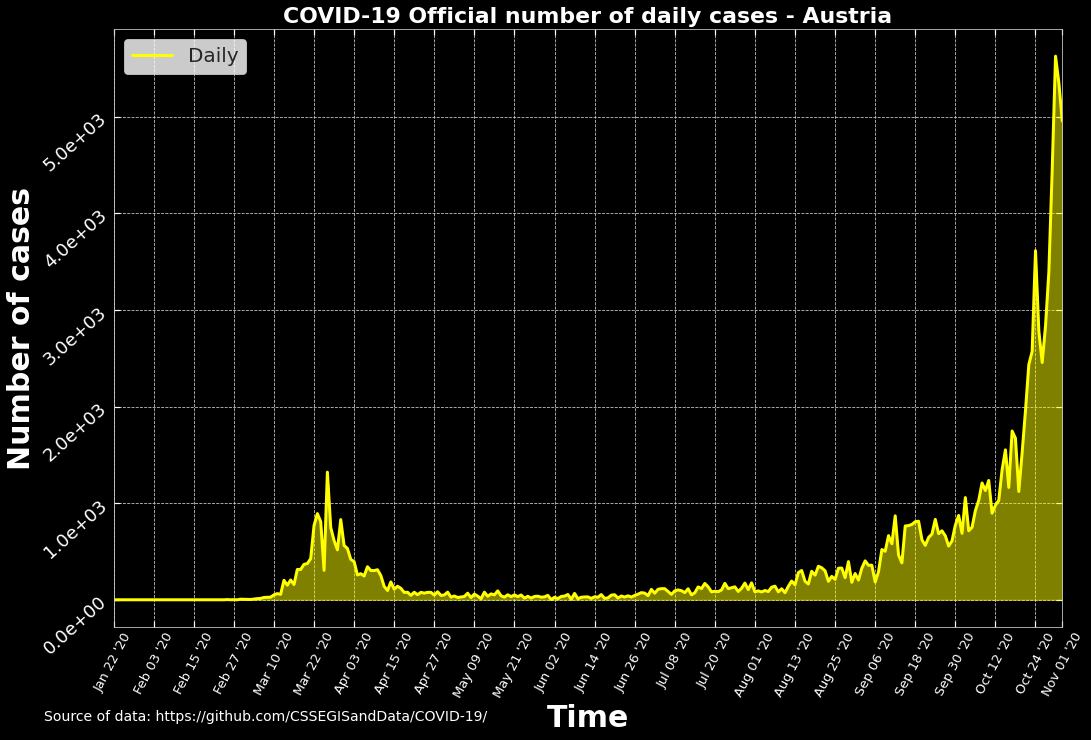

In [263]:
plot_region(region='Austria', mode='daily')

### Croatia

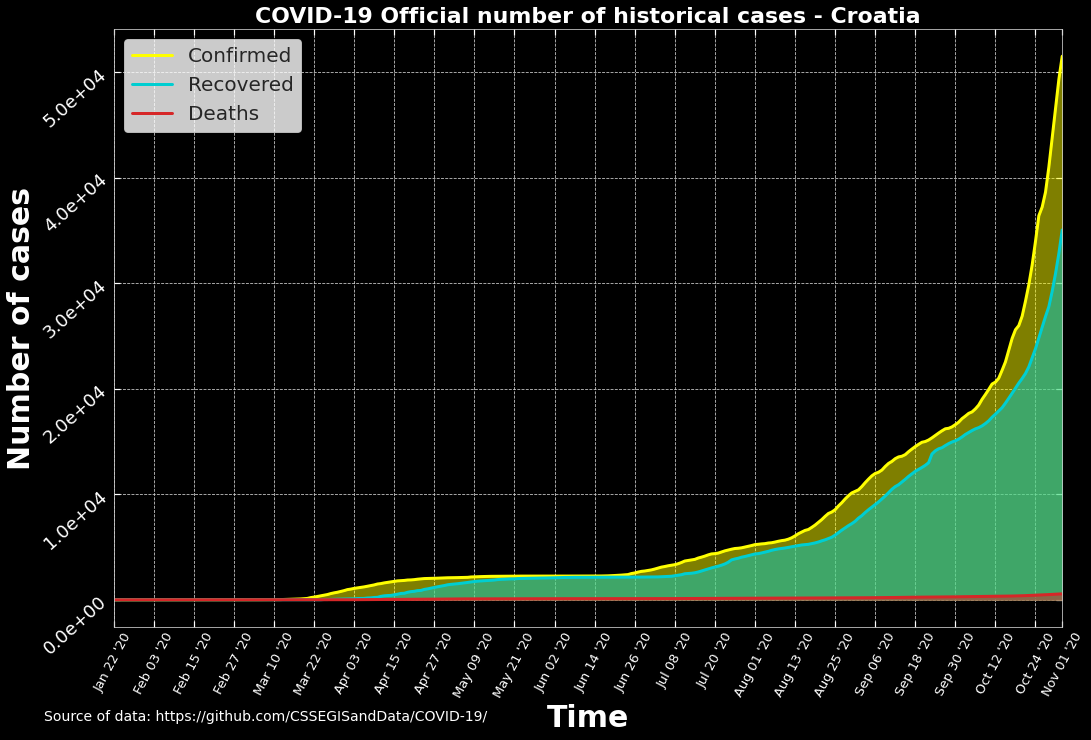

In [264]:
plot_region(region='Croatia', mode='full')

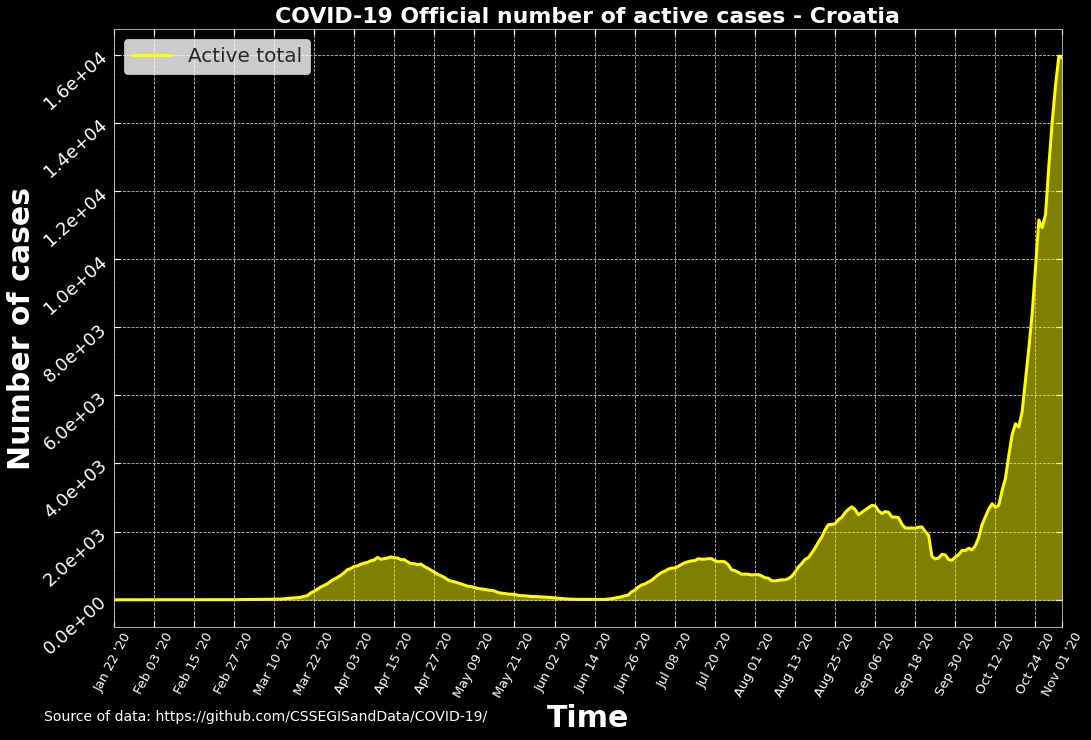

In [265]:
plot_region(region='Croatia', mode='total')

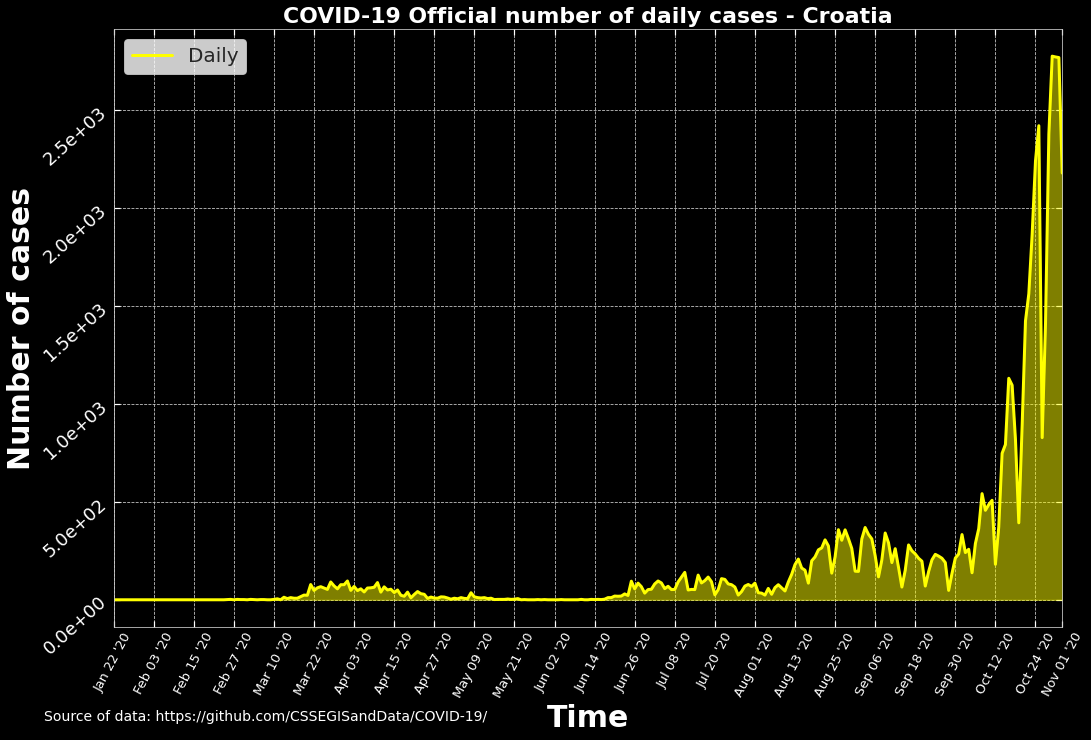

In [266]:
plot_region(region='Croatia', mode='daily')

### Slovakia

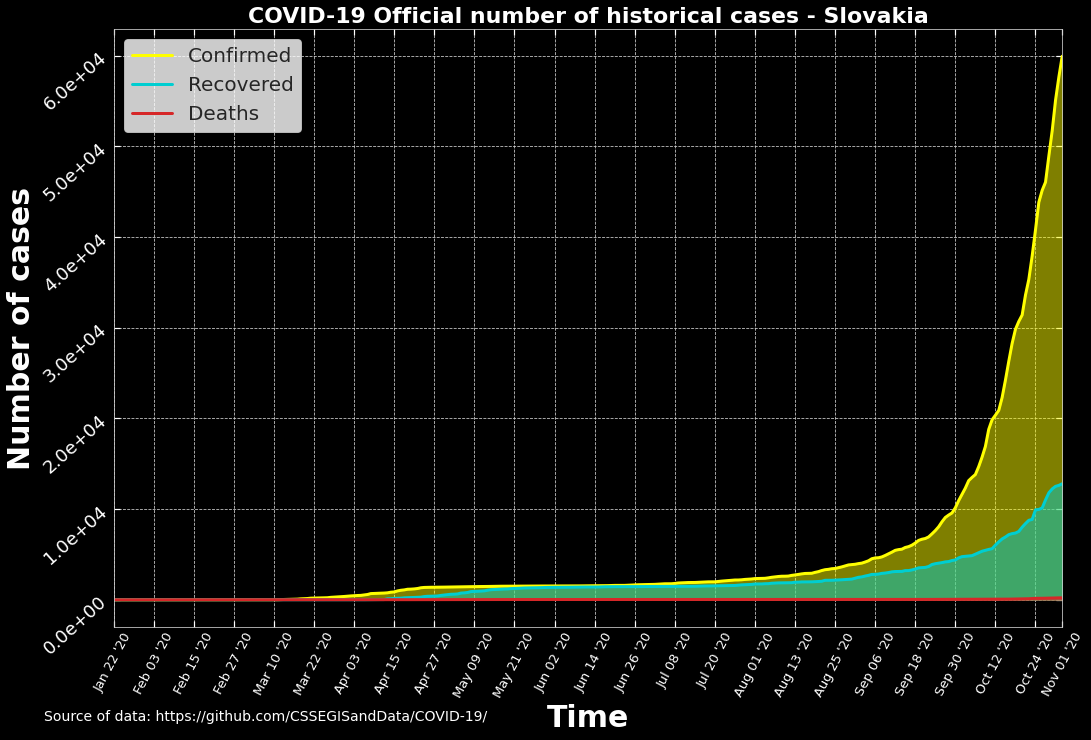

In [267]:
plot_region(region='Slovakia', mode='full')

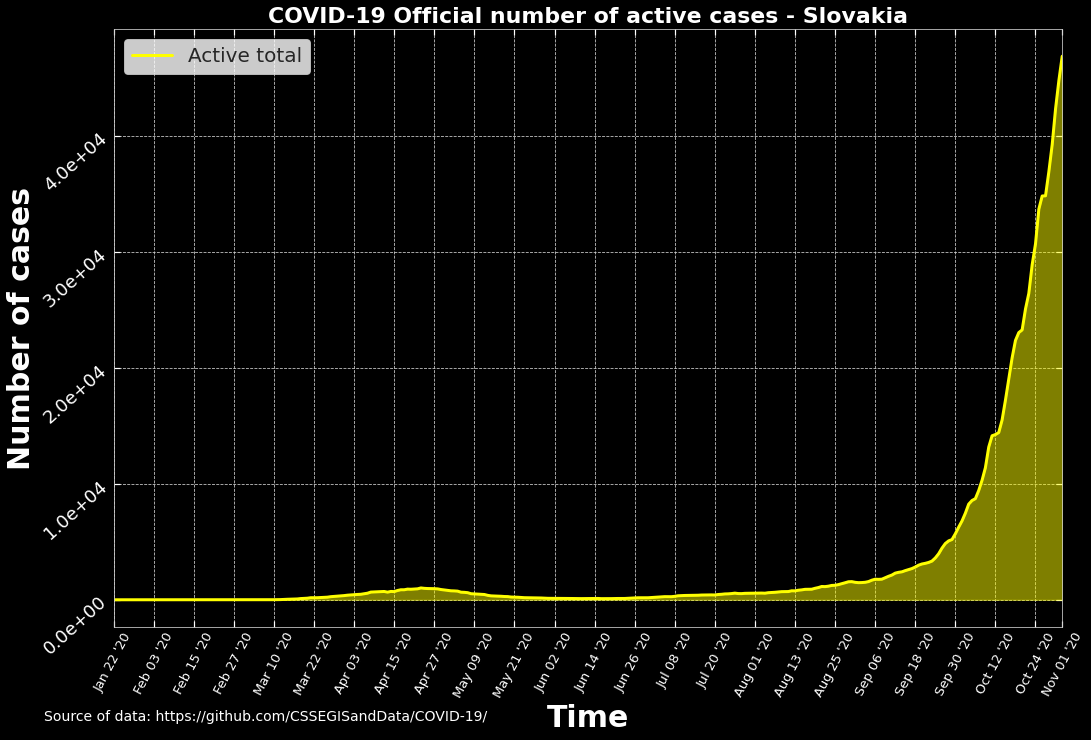

In [268]:
plot_region(region='Slovakia', mode='total')

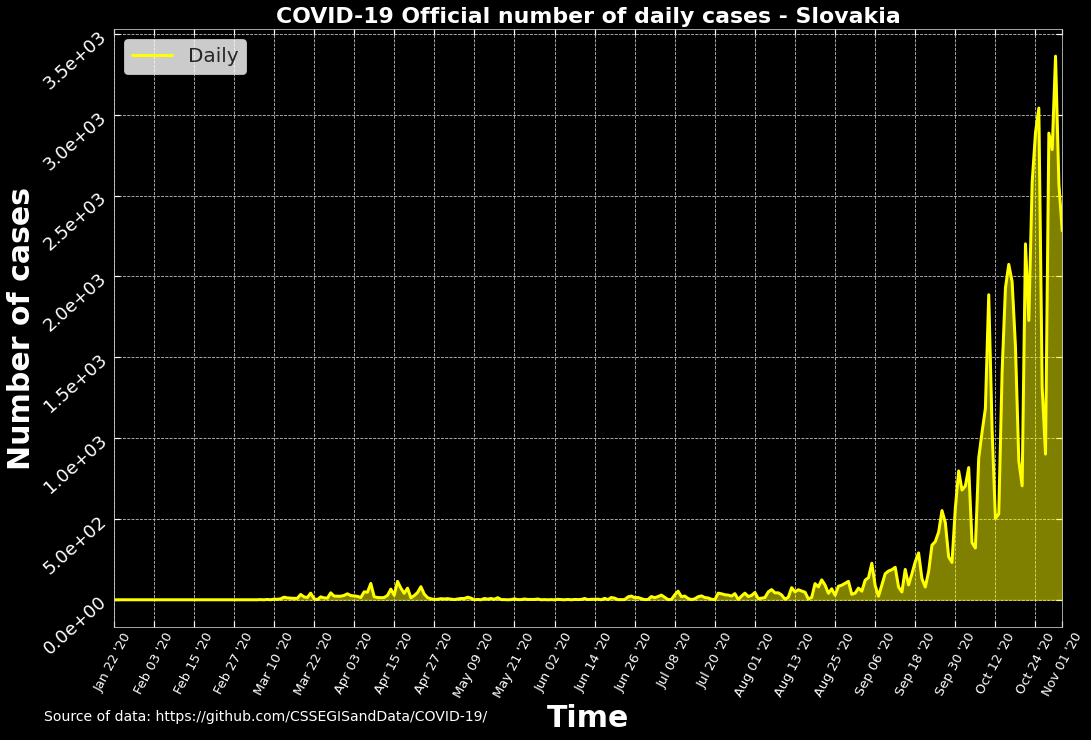

In [269]:
plot_region(region='Slovakia', mode='daily')

### Romania

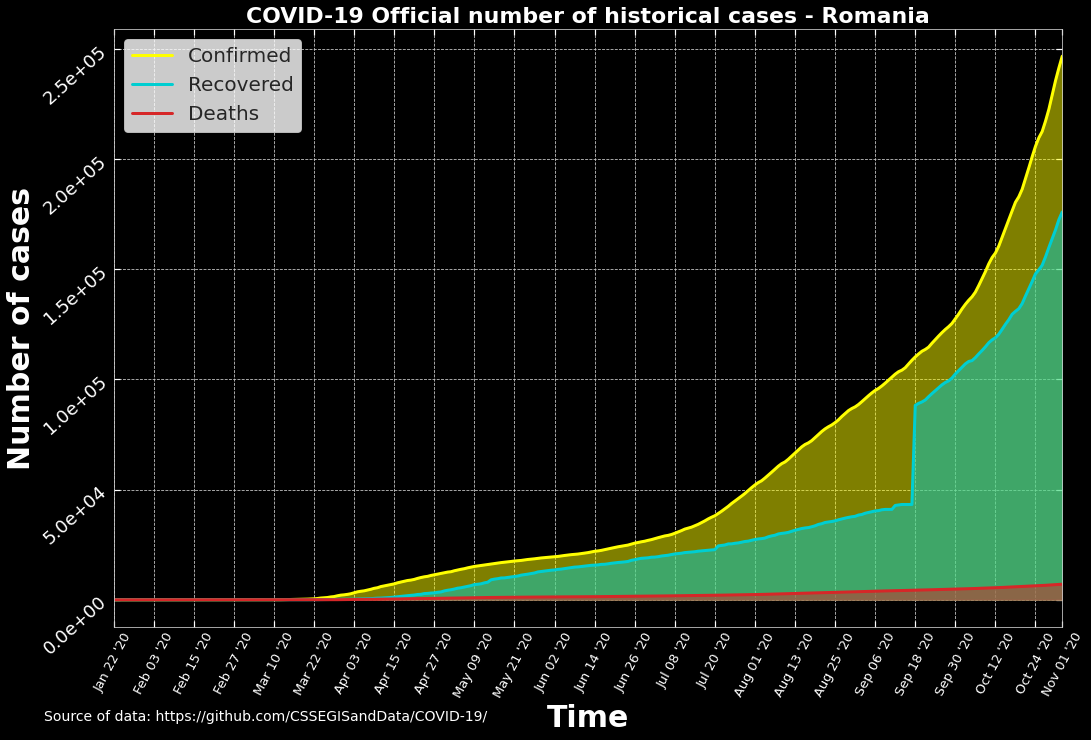

In [270]:
plot_region(region='Romania', mode='full')

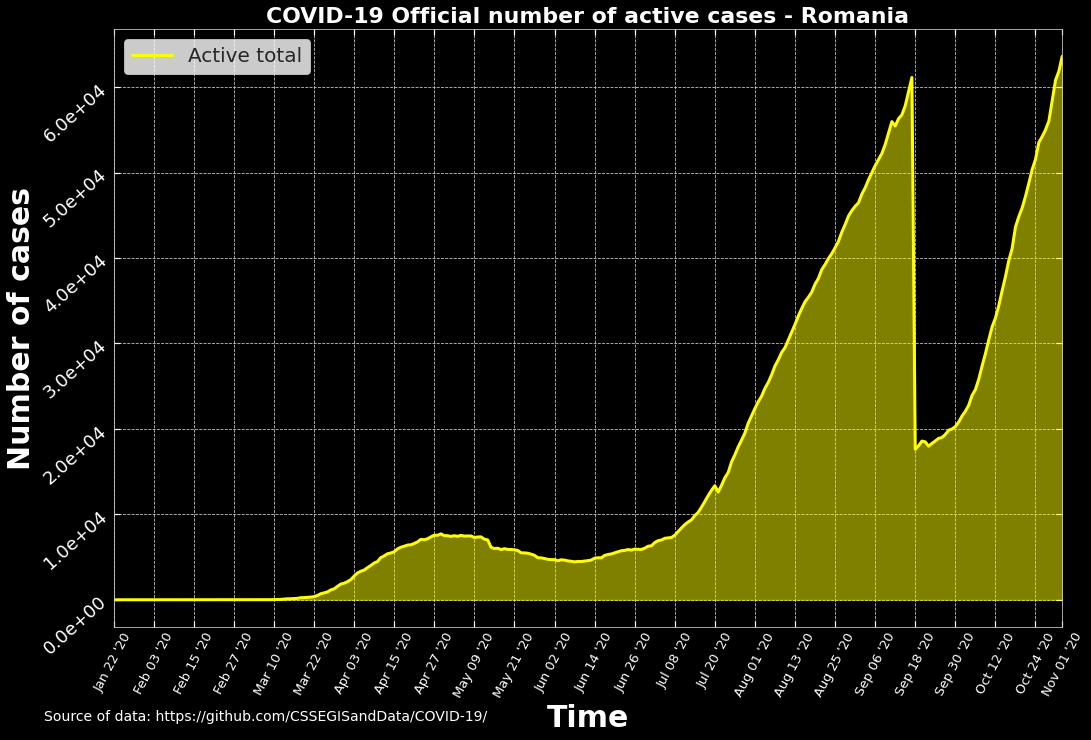

In [271]:
plot_region(region='Romania', mode='total')

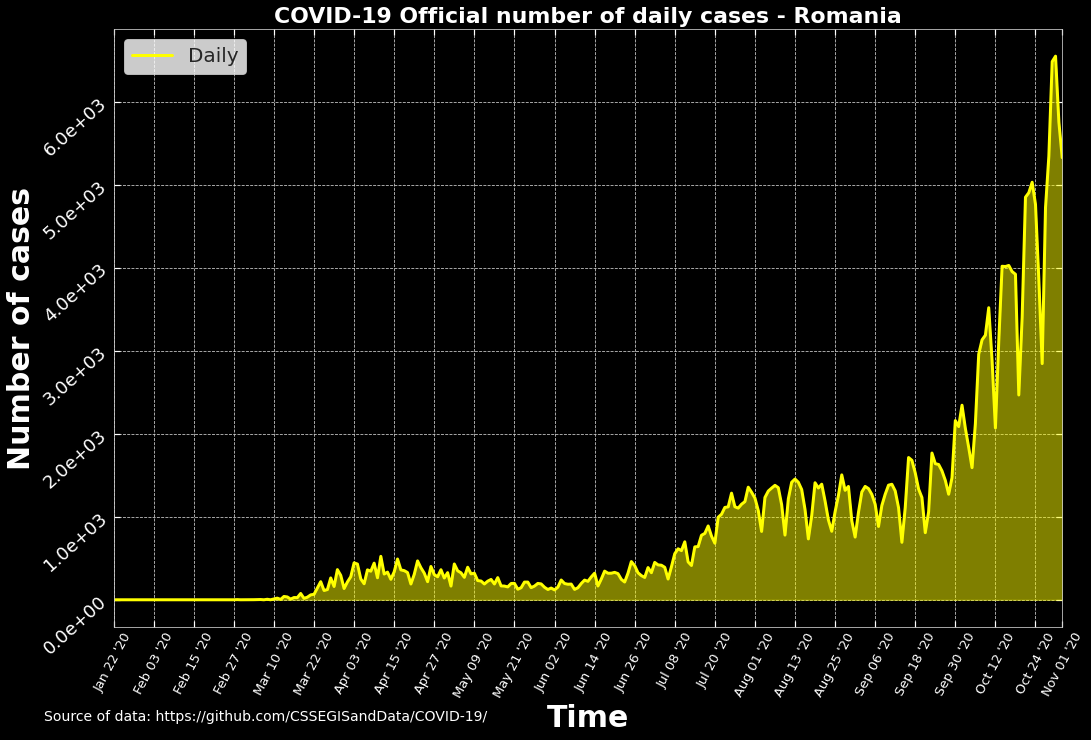

In [272]:
plot_region(region='Romania', mode='daily')

## Regions -- Europe other

### Italy

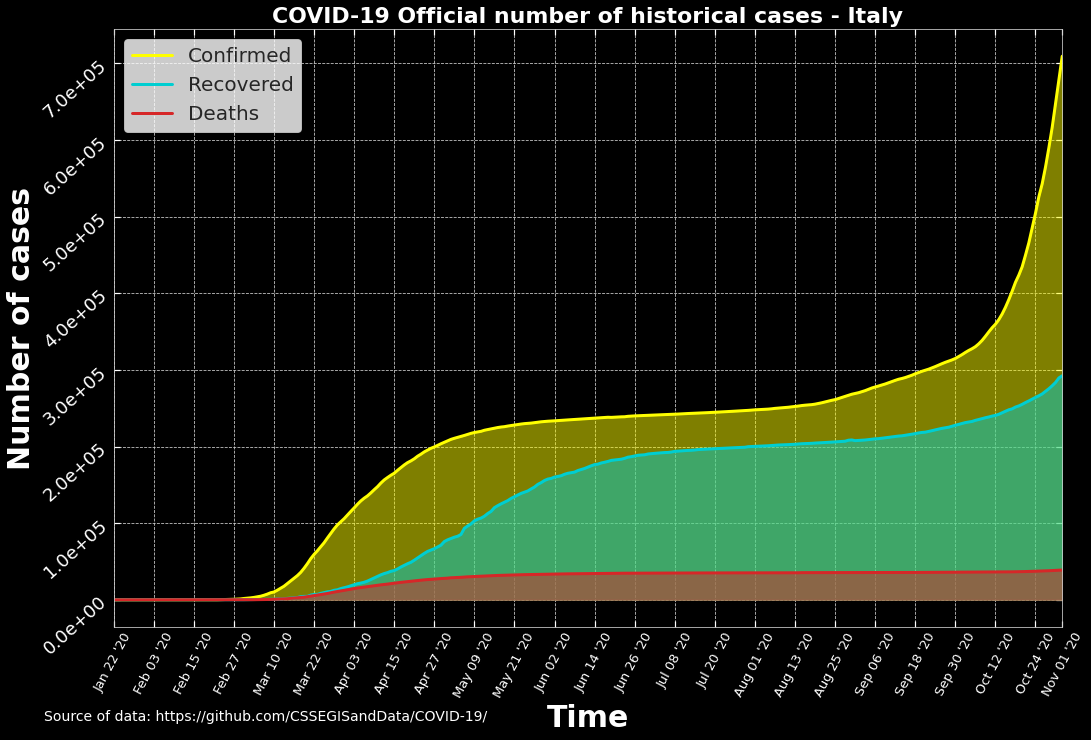

In [273]:
plot_region(region='Italy', mode='full')

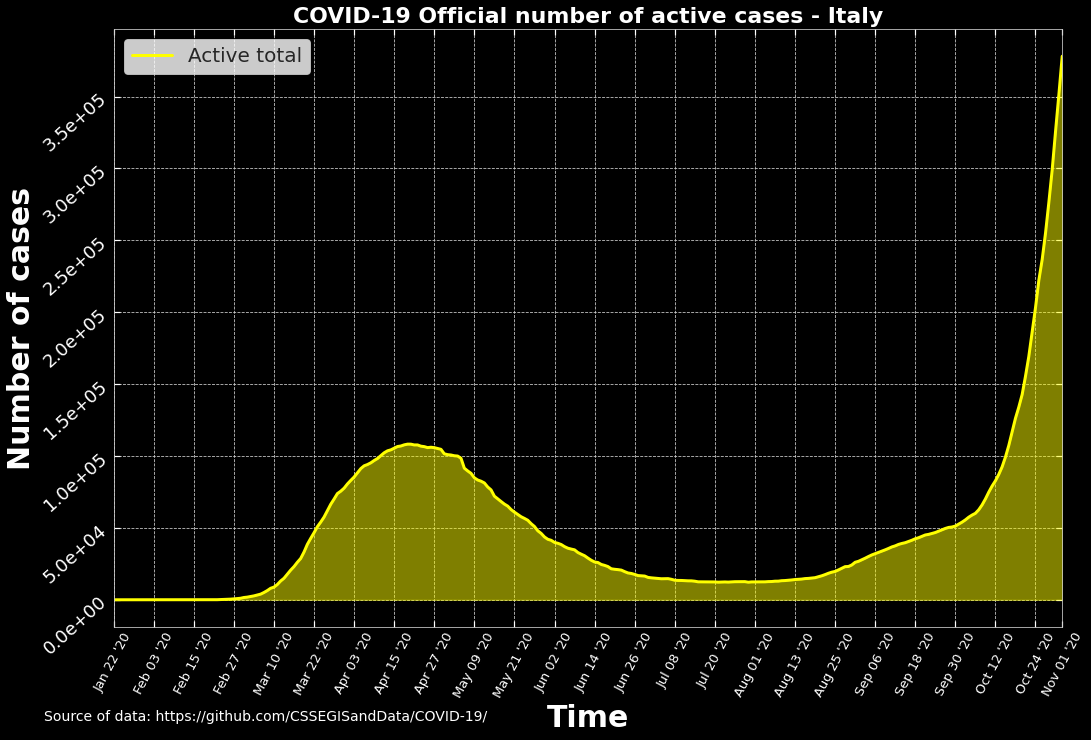

In [274]:
plot_region(region='Italy', mode='total')

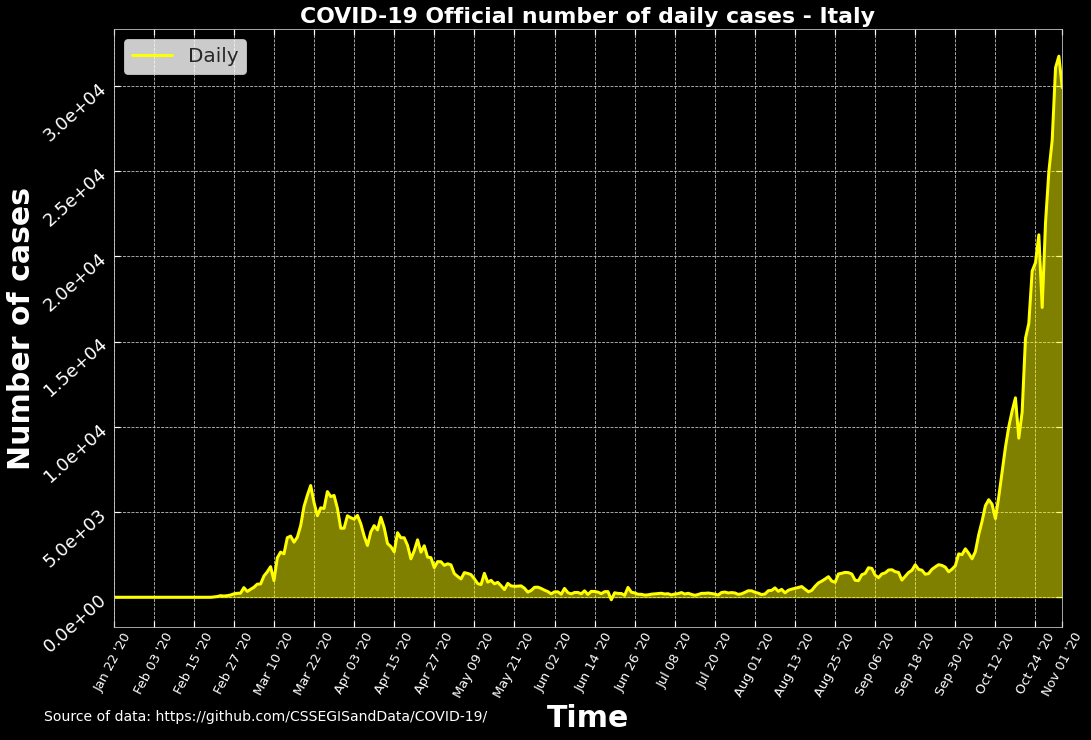

In [275]:
plot_region(region='Italy', mode='daily')

### France

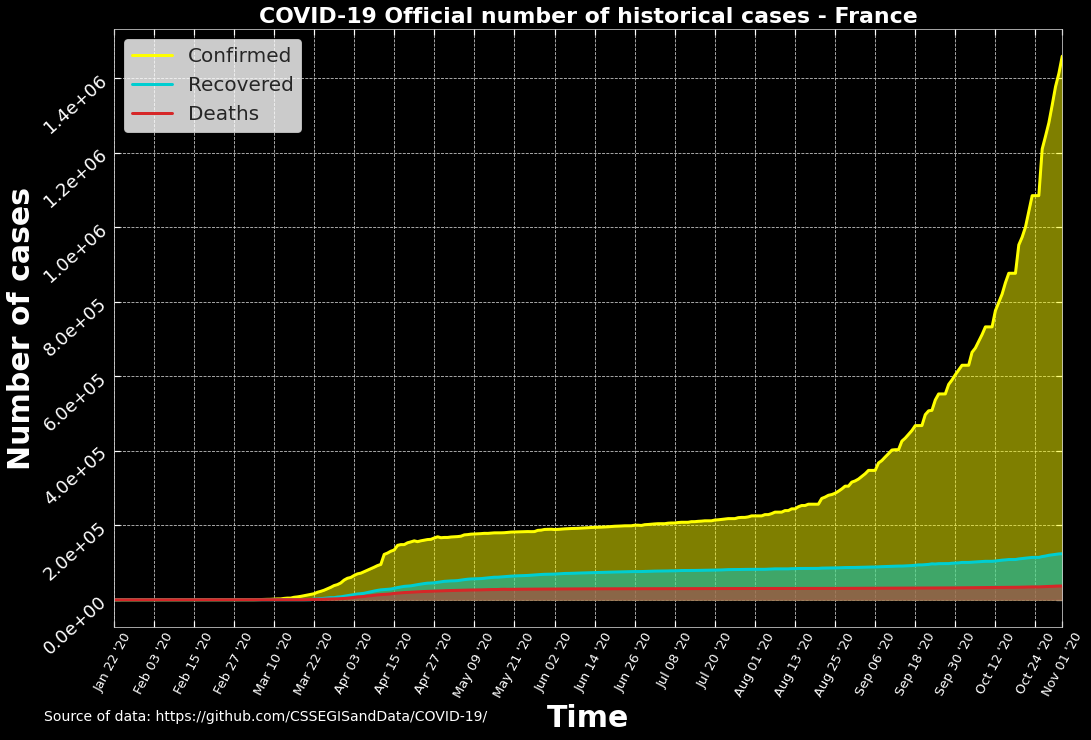

In [276]:
plot_region(region='France', mode='full')

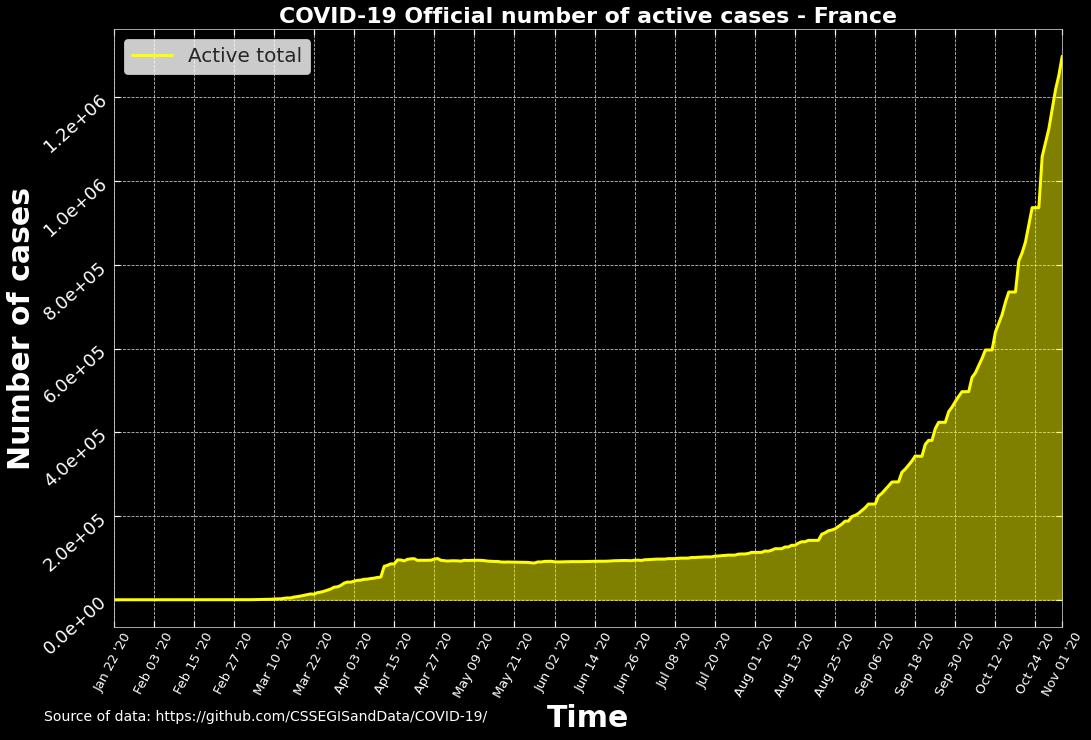

In [277]:
plot_region(region='France', mode='total')

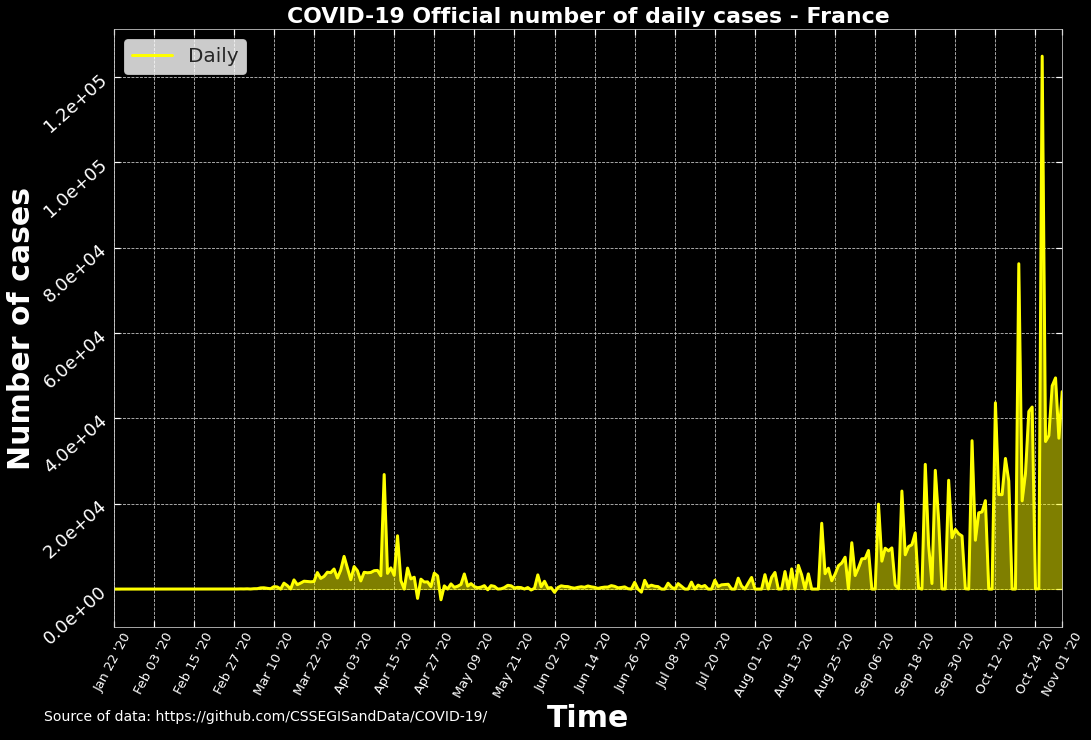

In [278]:
plot_region(region='France', mode='daily')

### Germany

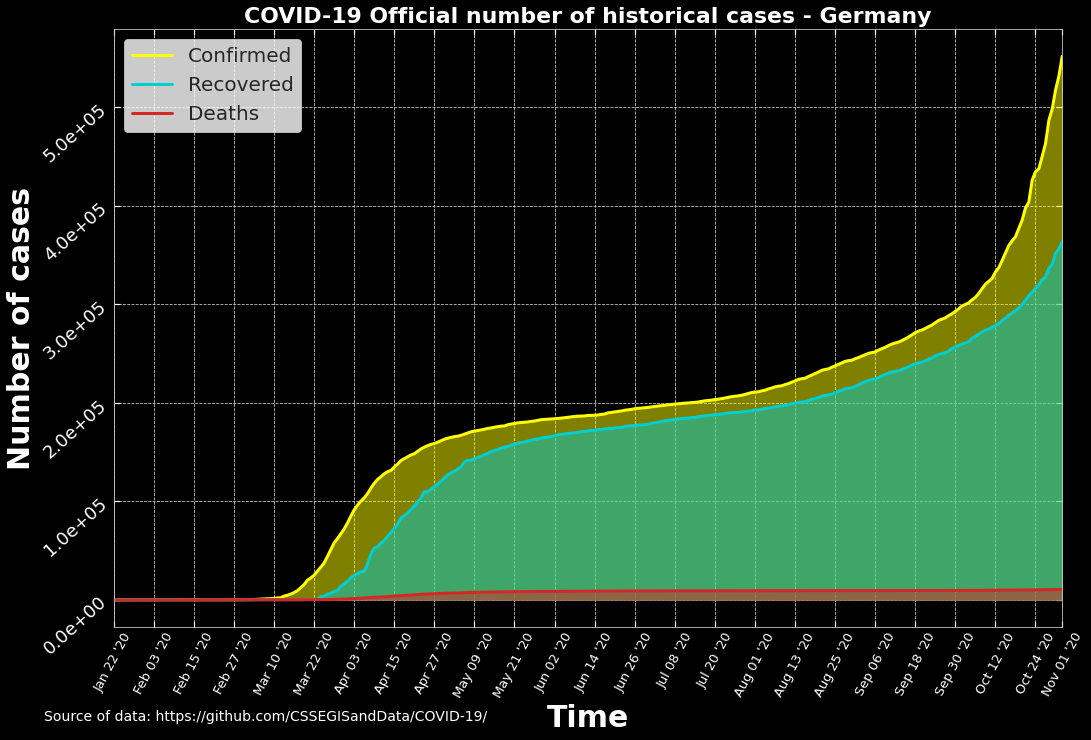

In [279]:
plot_region(region='Germany', mode='full')

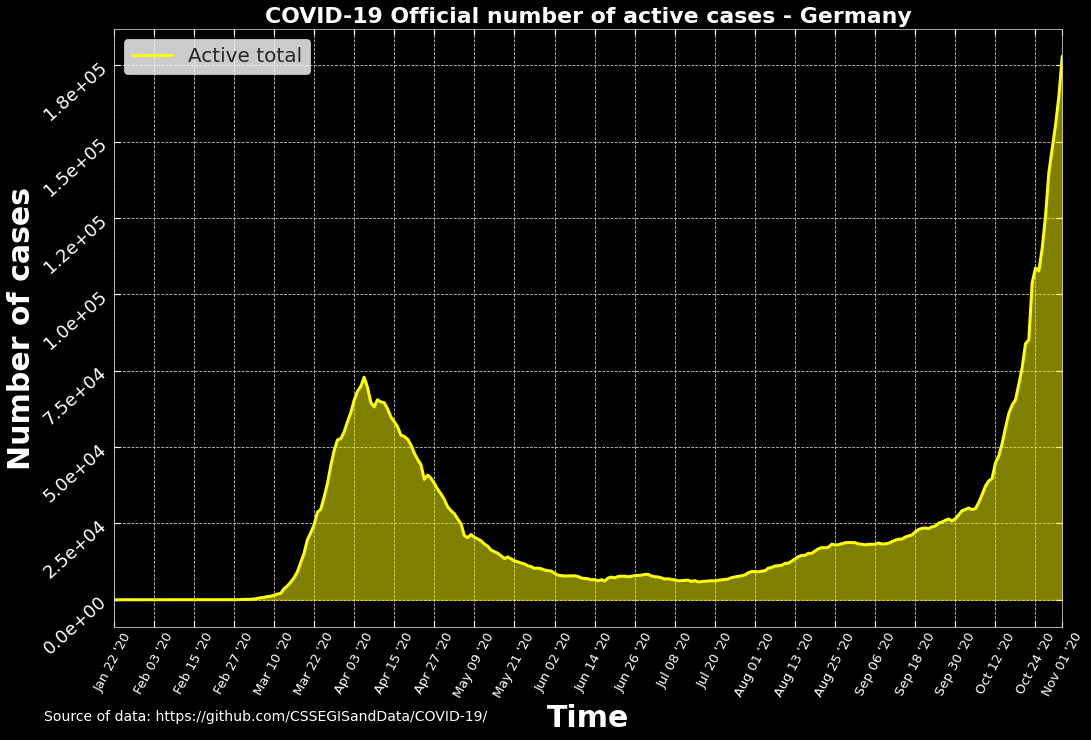

In [280]:
plot_region(region='Germany', mode='total')

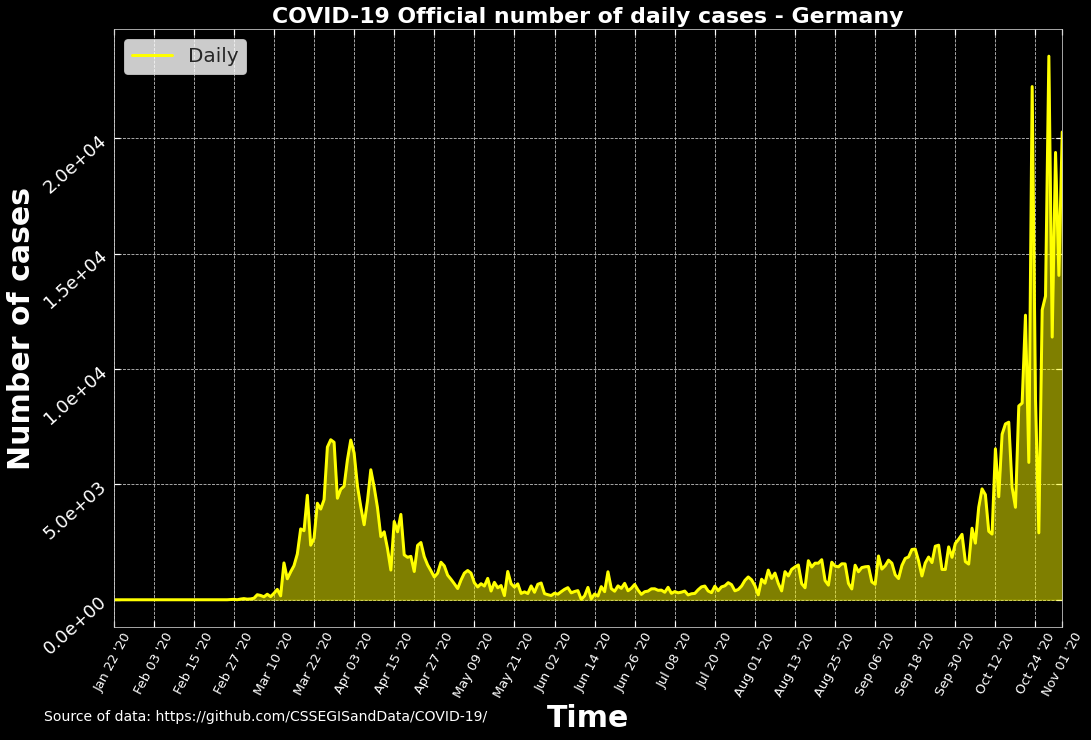

In [281]:
plot_region(region='Germany', mode='daily')

### Switzerland

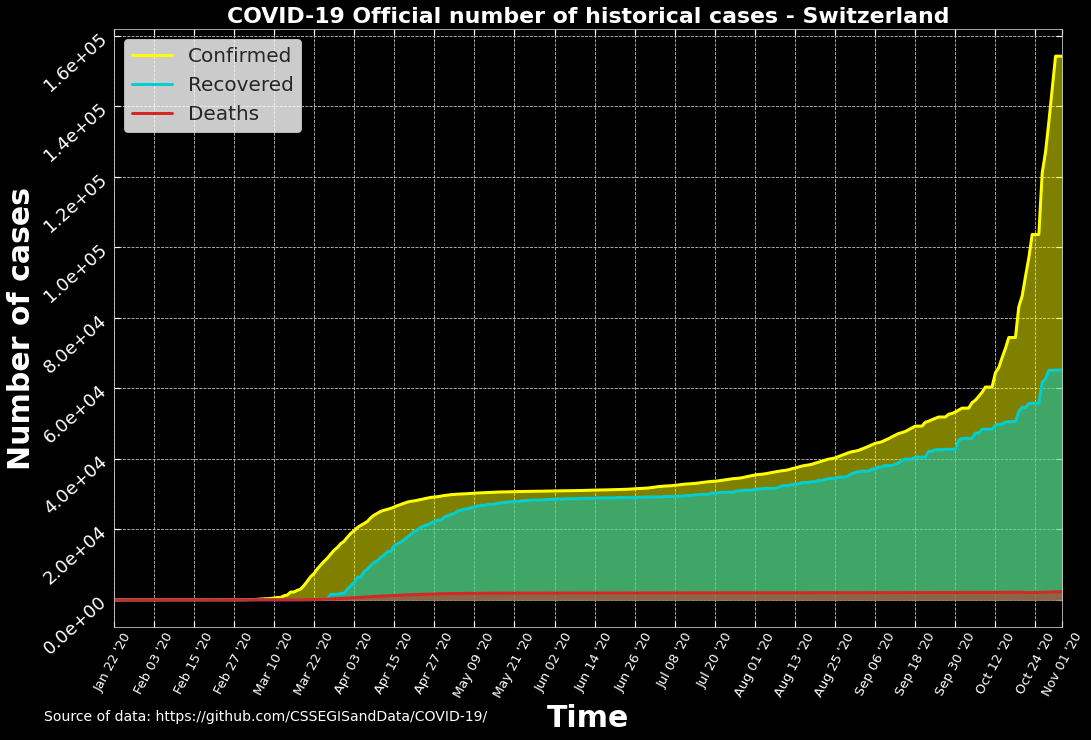

In [282]:
plot_region(region='Switzerland', mode='full')

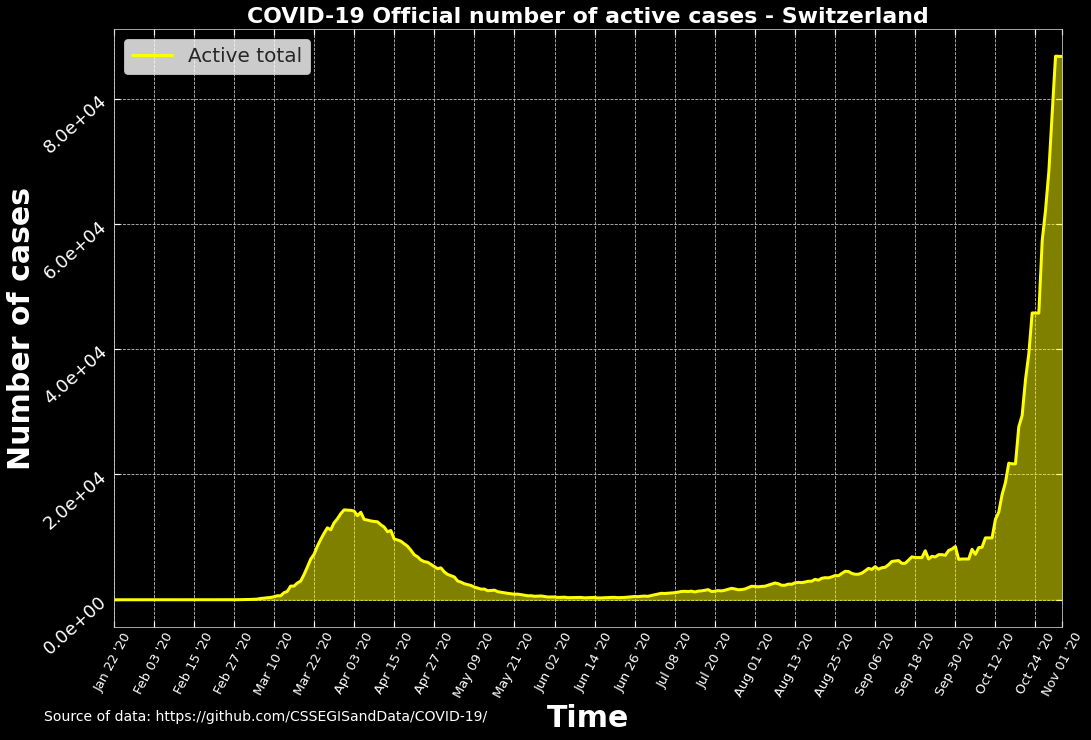

In [283]:
plot_region(region='Switzerland', mode='total')

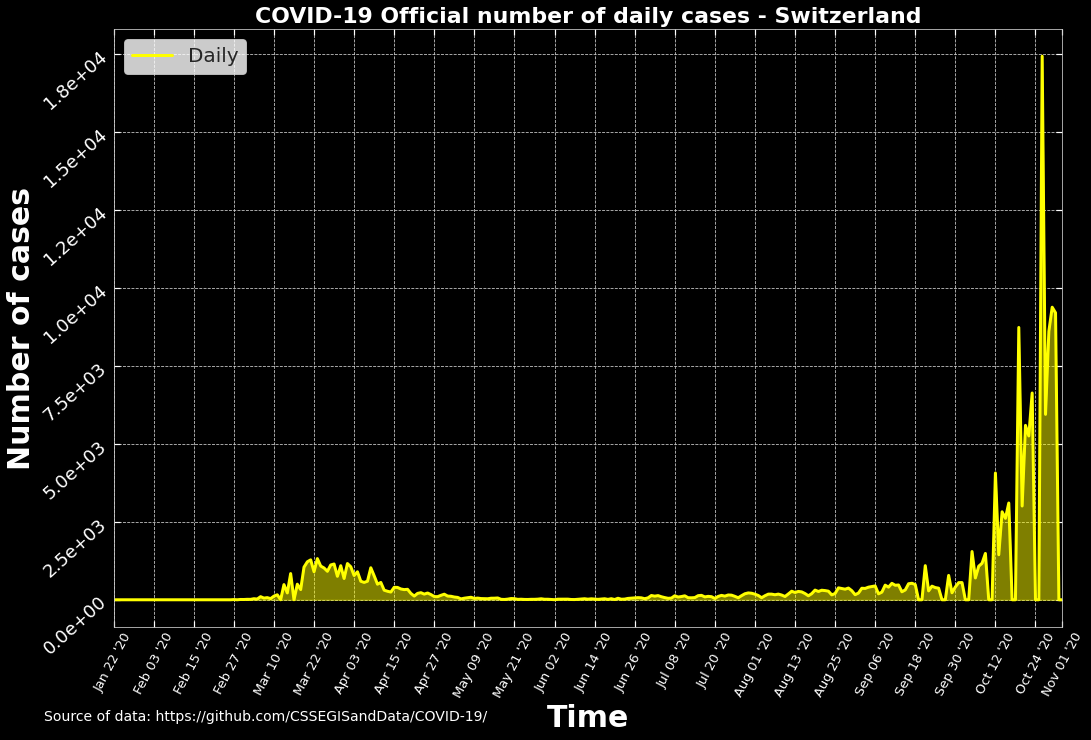

In [284]:
plot_region(region='Switzerland', mode='daily')

## Regions -- World

### United Kingdom

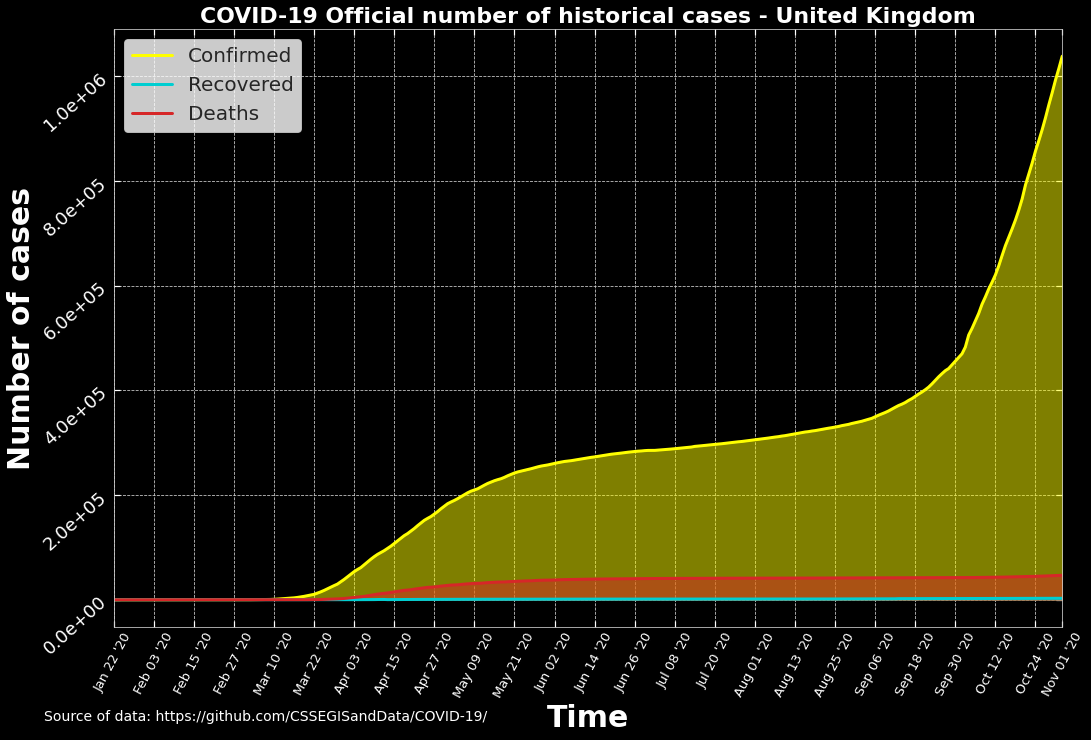

In [285]:
plot_region(region='United Kingdom', mode='full')

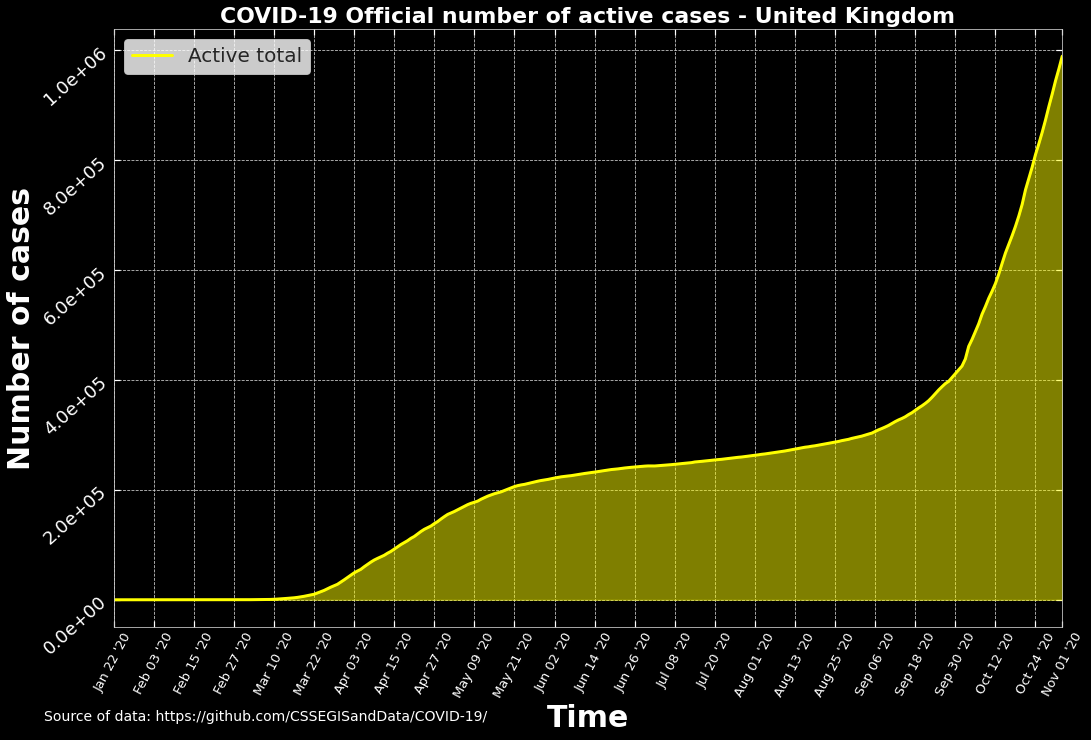

In [286]:
plot_region(region='United Kingdom', mode='total')

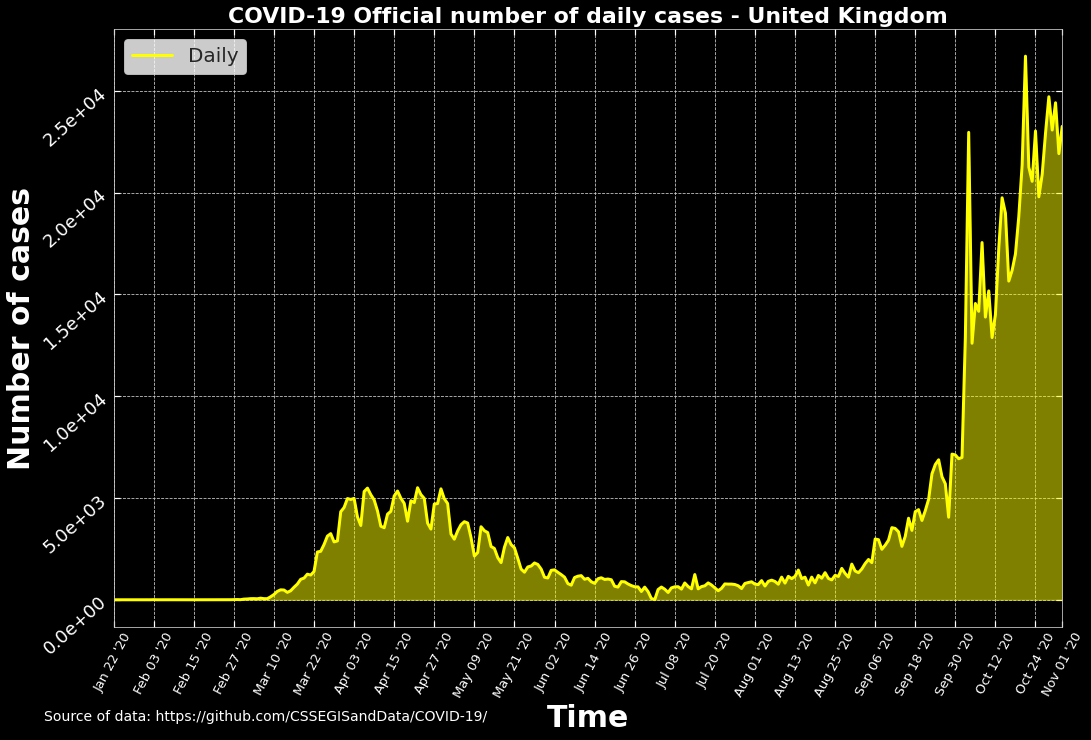

In [287]:
plot_region(region='United Kingdom', mode='daily')

### Mainland China

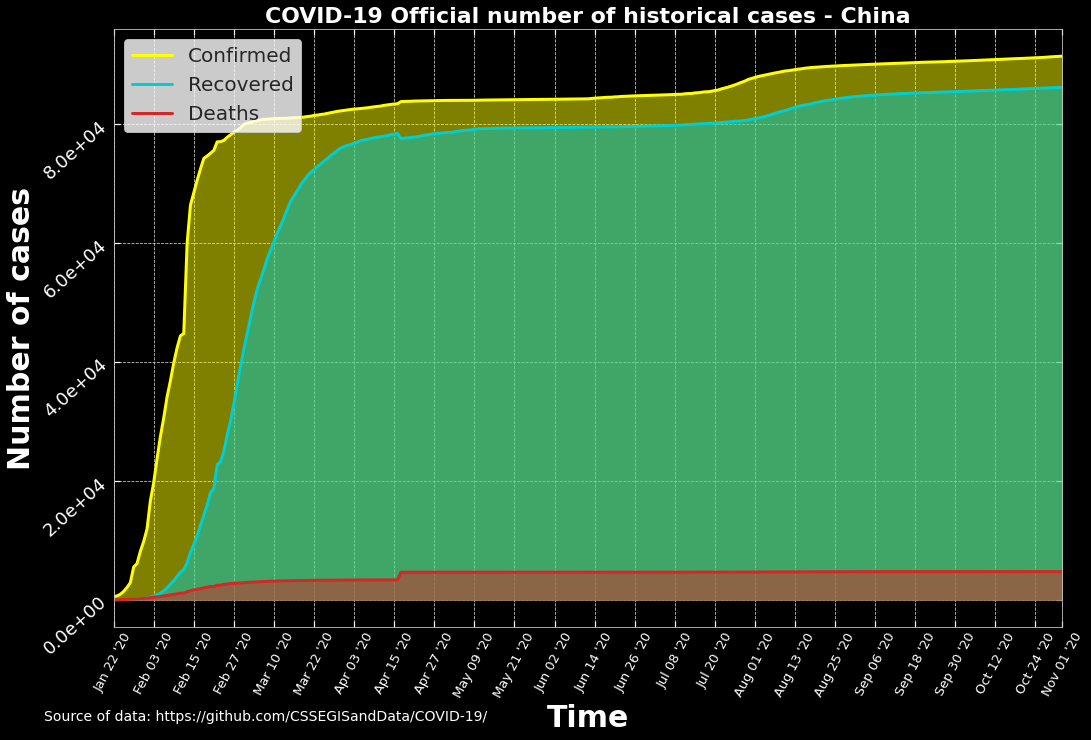

In [288]:
plot_region(region='China', mode='full')

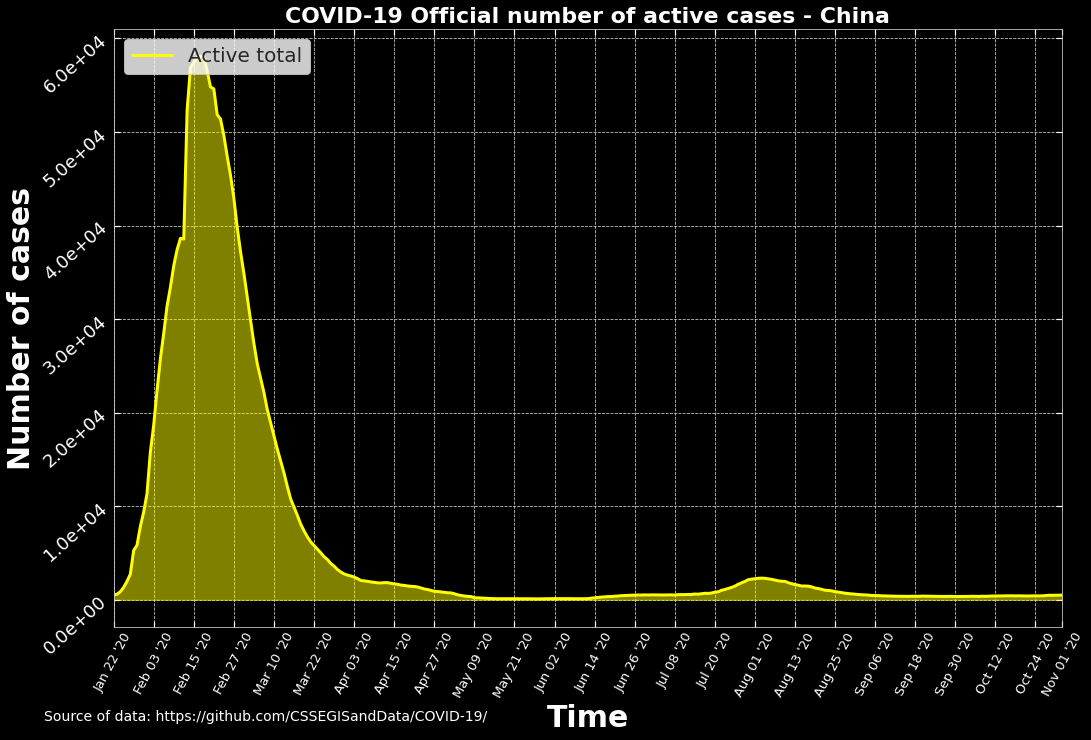

In [289]:
plot_region(region='China', mode='total')

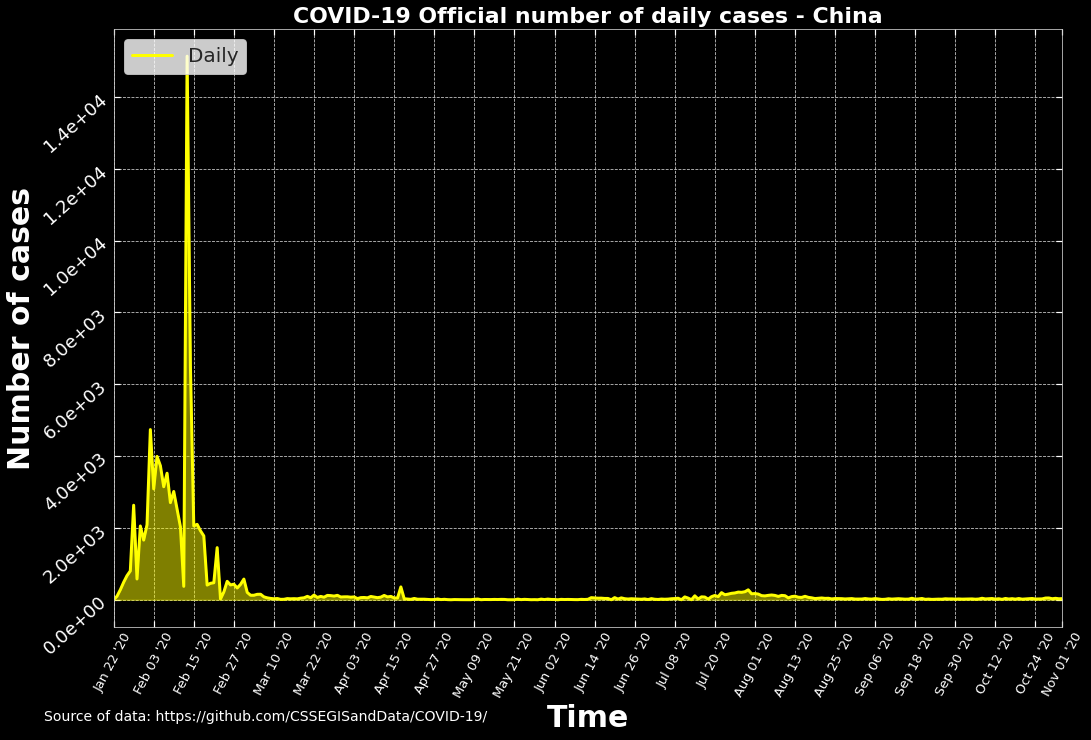

In [290]:
plot_region(region='China', mode='daily')

### South Korea

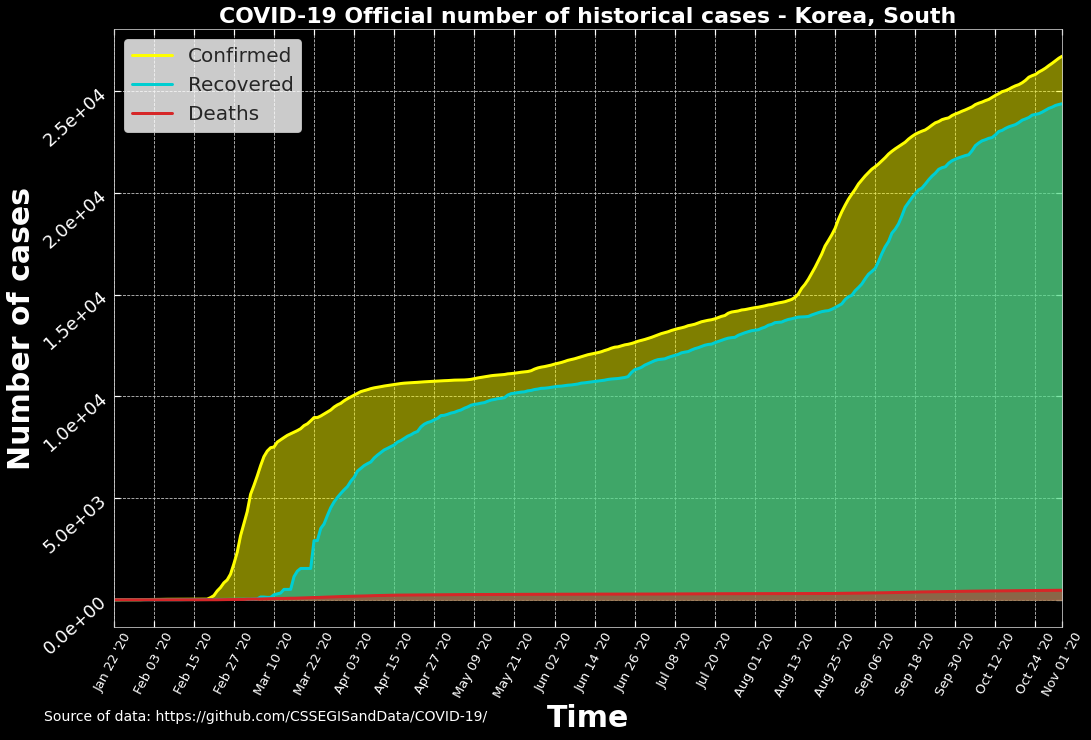

In [291]:
plot_region(region='Korea, South', mode='full')

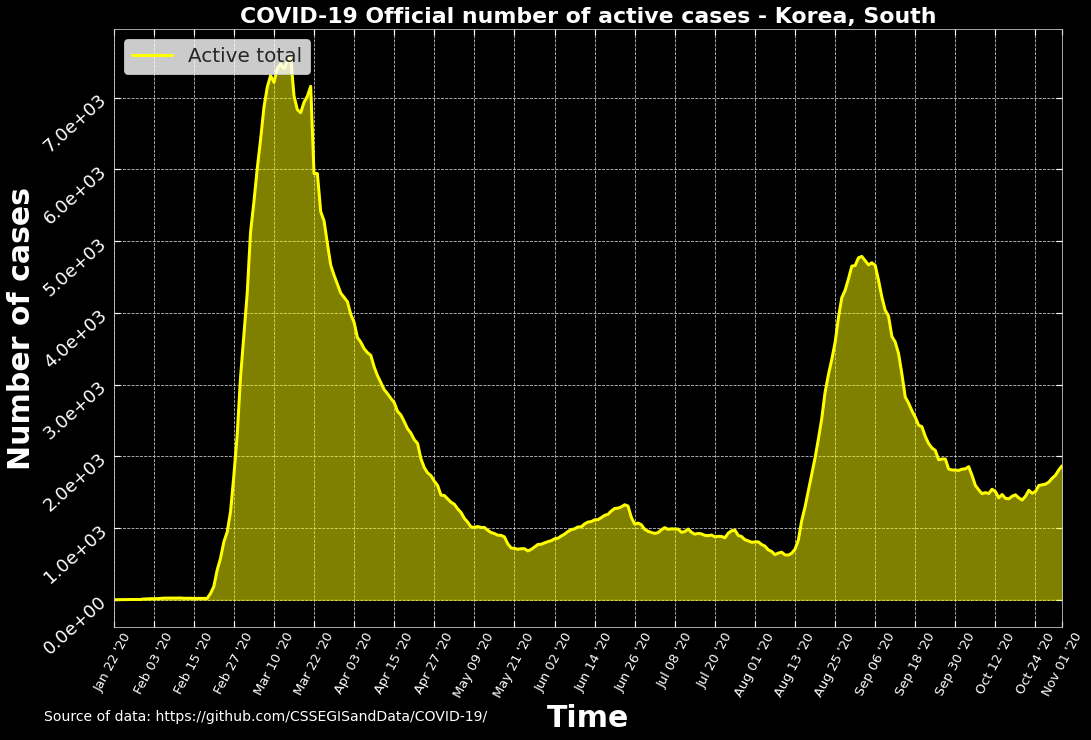

In [292]:
plot_region(region='Korea, South', mode='total')

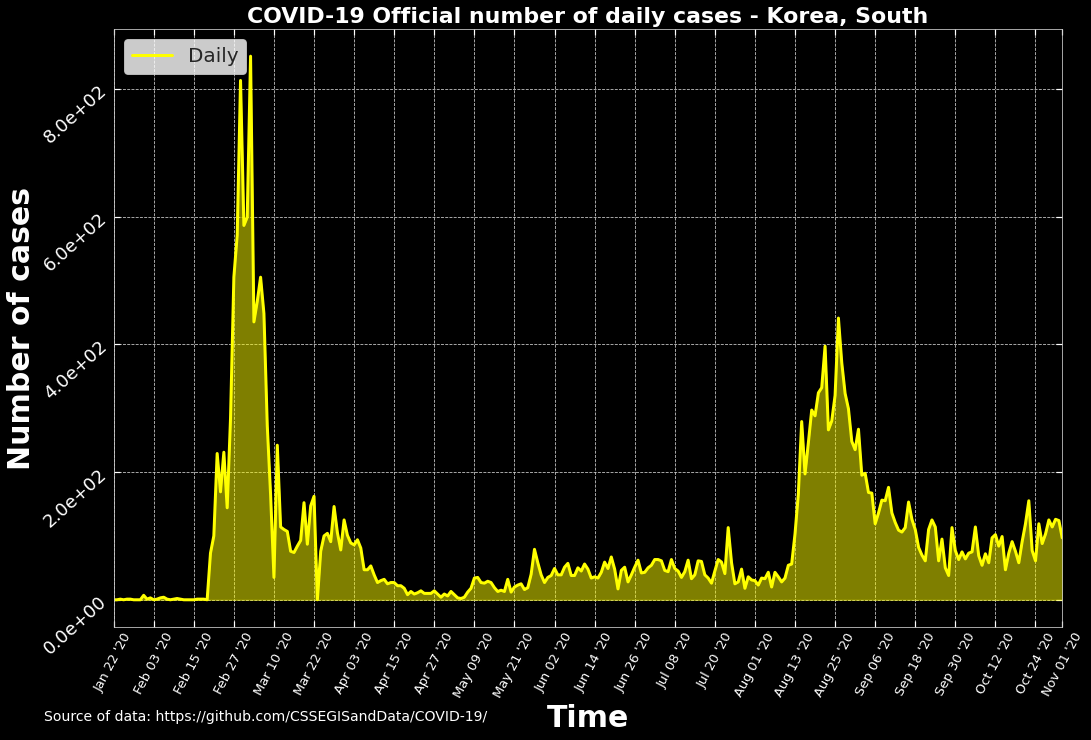

In [293]:
plot_region(region='Korea, South', mode='daily')

### Iran

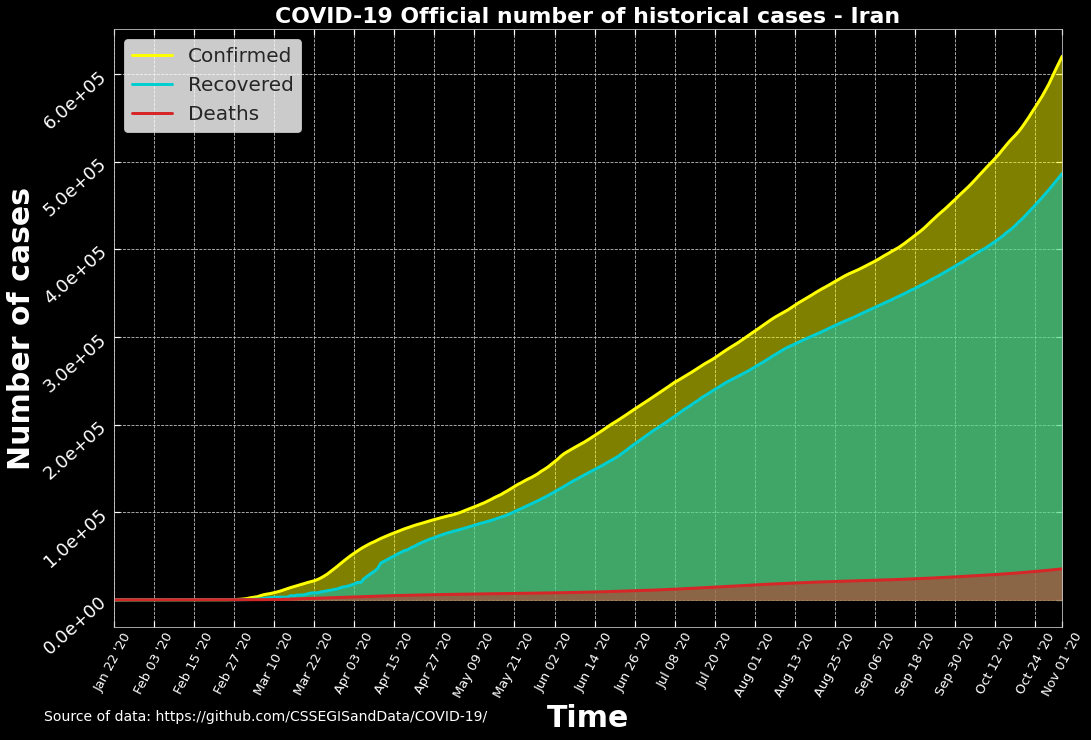

In [294]:
plot_region(region='Iran', mode='full')

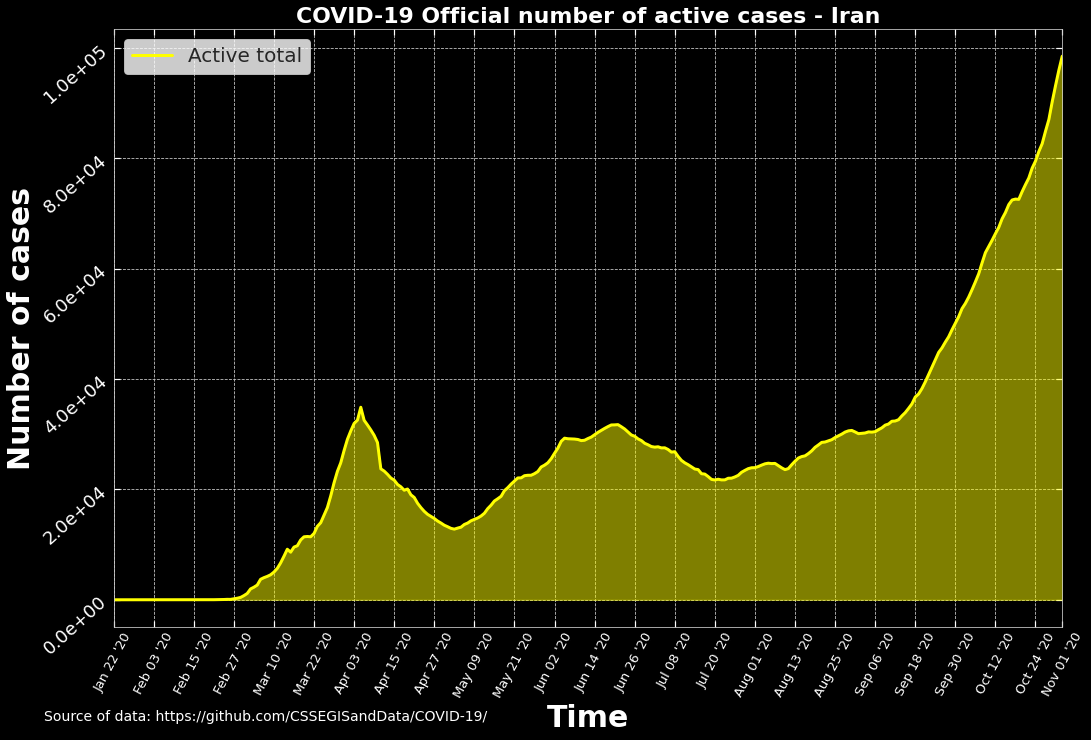

In [295]:
plot_region(region='Iran', mode='total')

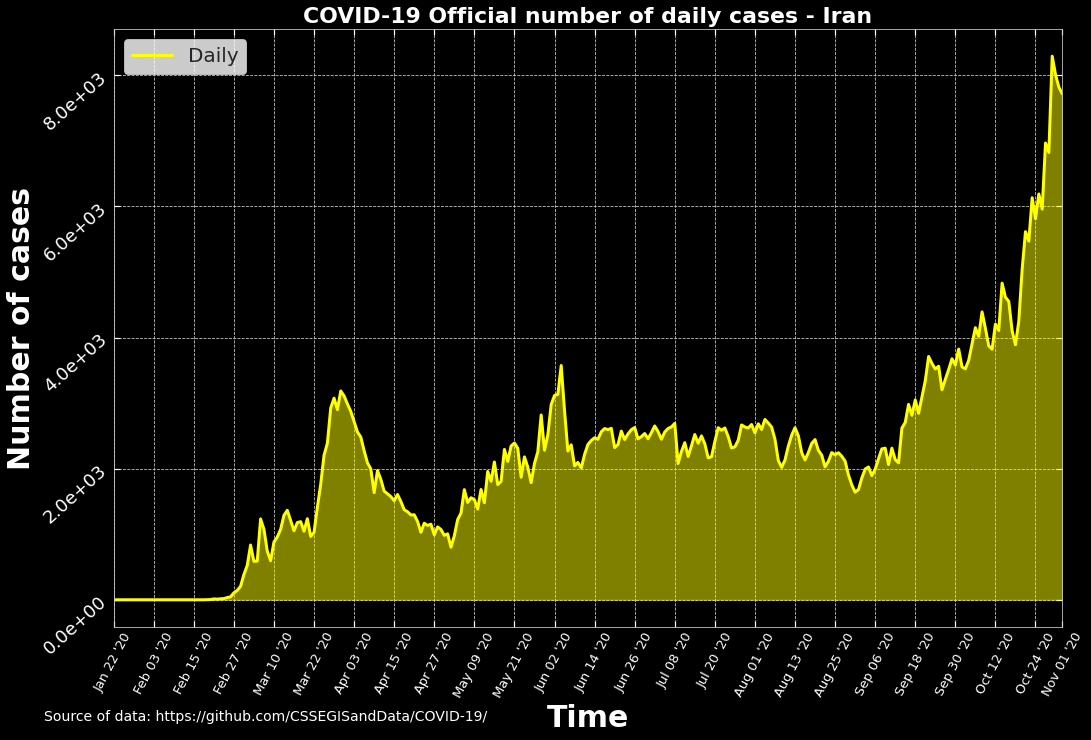

In [296]:
plot_region(region='Iran', mode='daily')

### India

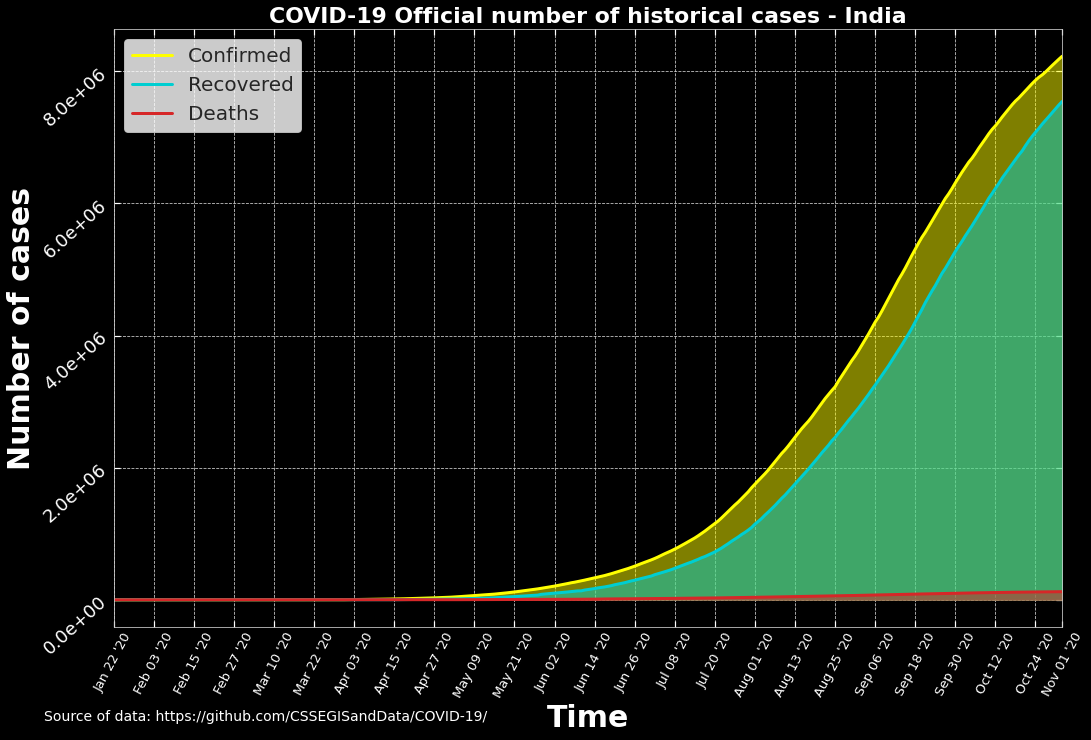

In [297]:
plot_region(region='India', mode='full')

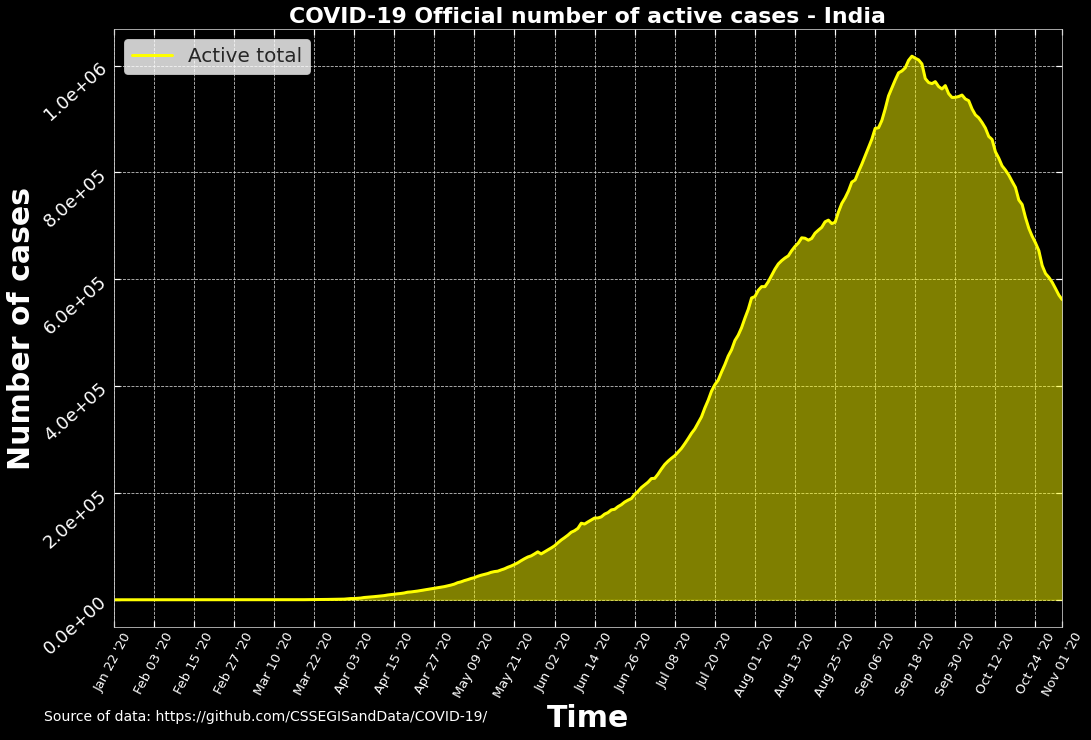

In [298]:
plot_region(region='India', mode='total')

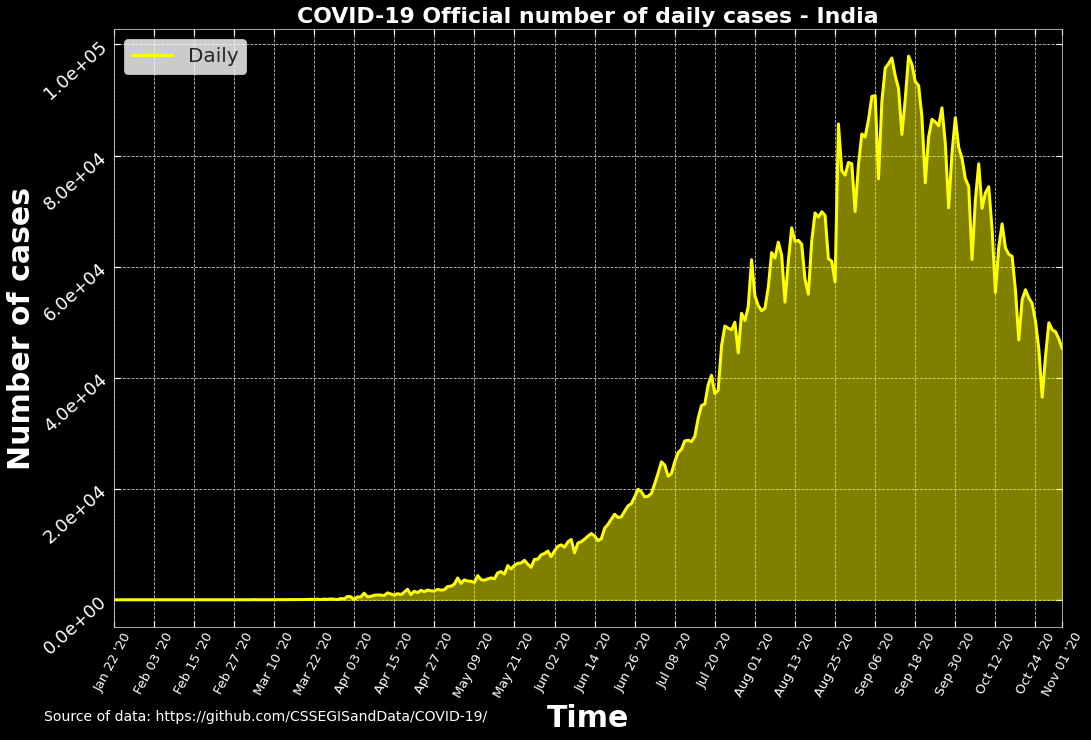

In [299]:
plot_region(region='India', mode='daily')

### Spain

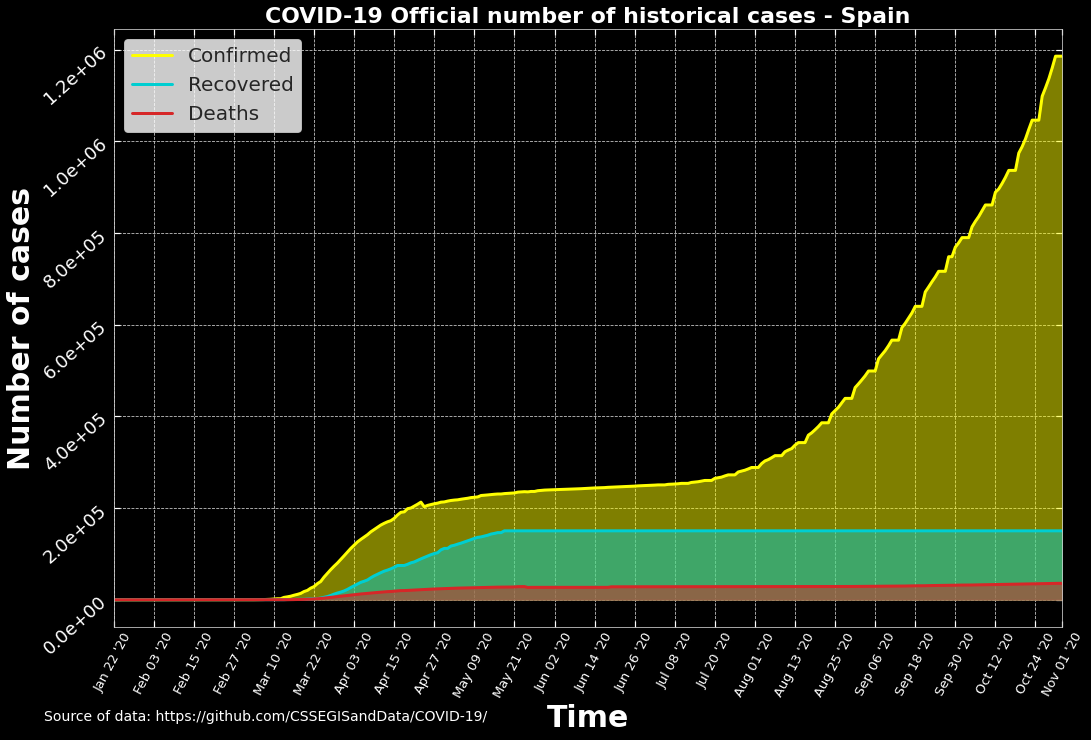

In [300]:
plot_region(region='Spain', mode='full')

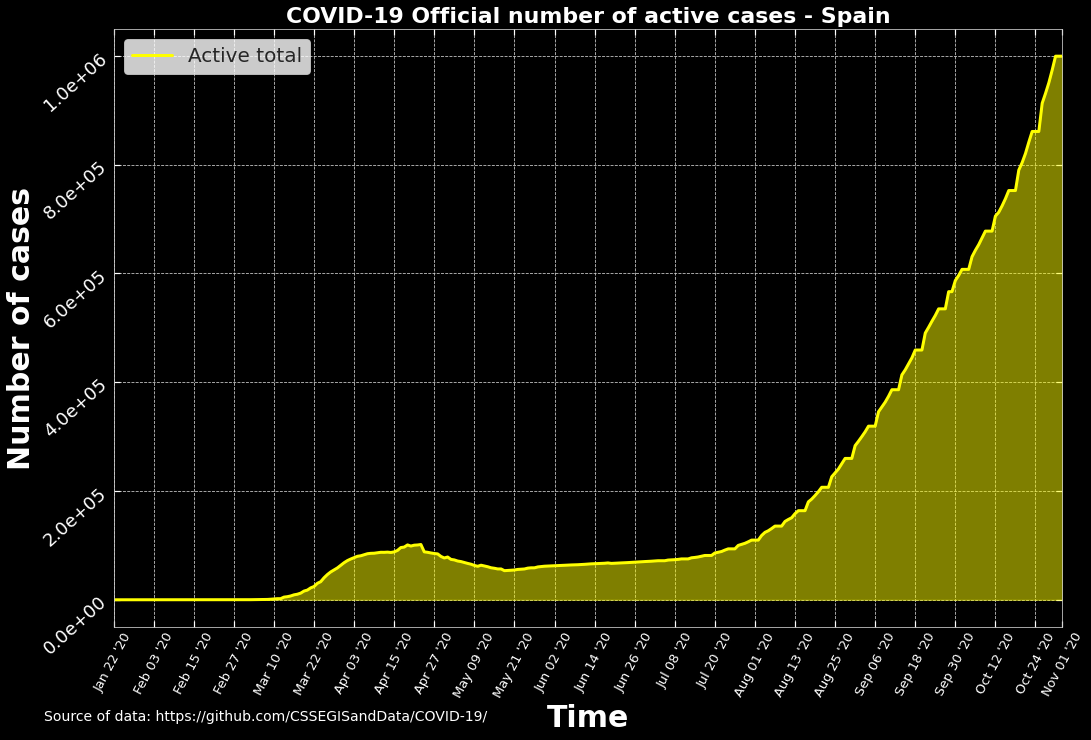

In [301]:
plot_region(region='Spain', mode='total')

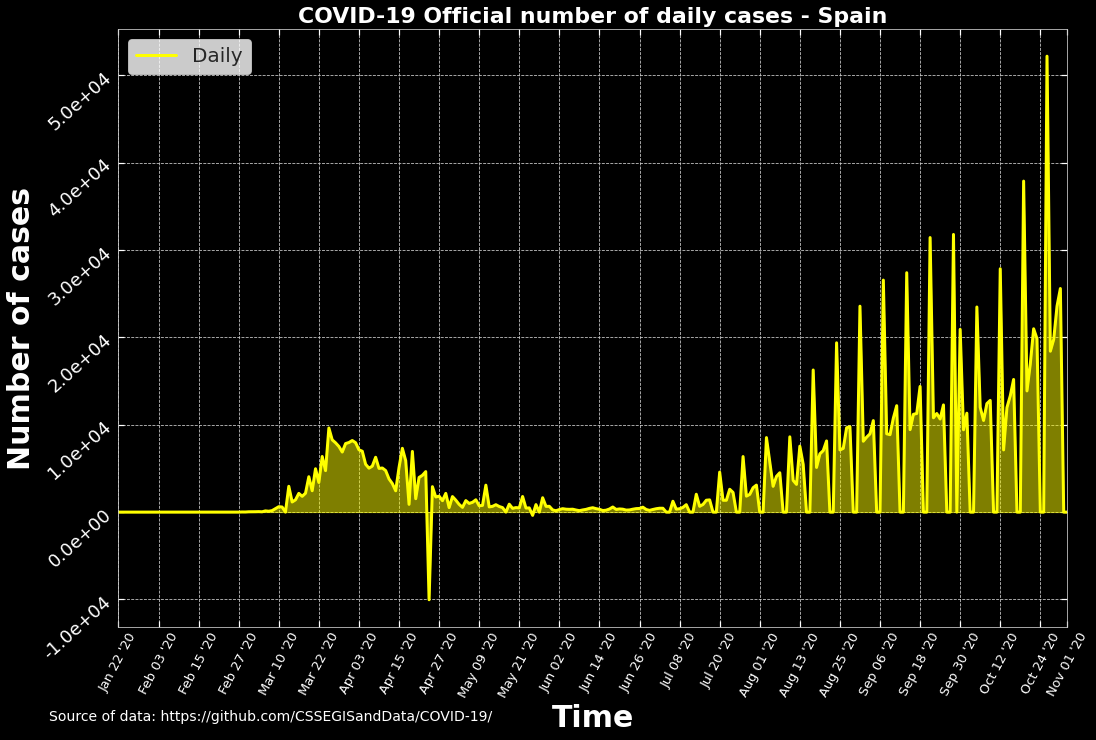

In [302]:
plot_region(region='Spain', mode='daily')